In [1]:
# imports
import yaml
from typing import List, Dict, Tuple, TypeVar, Any
import numpy as np
from numpy.typing import NDArray
from queue import Queue
import matplotlib.pyplot as plt
import random as rand
import time

In [2]:
# # Enter world here
# with open('worlds.yml', 'r') as f:
#   worlds = yaml.safe_load(f)

# world = worlds['world_1']

# grid_2d = np.array(world['grid'])
# grid = grid_2d[np.newaxis, :, :]

# agent_start = np.array(world['agent_start'])[0]

# grid = np.repeat(grid, 8, axis=0)

# grid_height = grid.shape[1]
# grid_width = grid.shape[2]
# agent_position = agent_start

In [3]:
# def plot_simulation(agent_traj = , ):
#     # simulation
#     grid_height = grid.shape[1]
#     grid_width = grid.shape[2]
#     agent_position = agent_start

#     #TODO update outside instead of using dummy
#     agent_trajectory = [
#         (0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4)
#     ]

#     fig, ax = plt.subplots()

#     # plot grid
#     for y in range(grid_height):
#         for x in range(grid_width):
#             if grid_2d[y, x] == 0:
#                 color = 'white'
#             elif grid_2d[y, x] == 1:
#                 color = 'red'
#             else:
#                 color = 'green'
#             rect = plt.Rectangle((x, y), 1, 1, color=color, alpha=0.5)
#             ax.add_patch(rect)

#     # plot path
#     x_coords = [pos[0] + 0.5 for pos in agent_trajectory]
#     y_coords = [pos[1] + 0.5 for pos in agent_trajectory]
#     ax.plot(x_coords, y_coords, color='blue', linestyle='-', linewidth=3)


#     # plot agebt;s initial position
#     ax.plot(agent_position[0] + 0.5, agent_position[1] + 0.5, marker='o', markersize=8, color='red', label='Start')

#     # plot attributes
#     plt.title('Grid World Simulation')
#     plt.xlabel('X-axis')
#     plt.ylabel('Y-axis')
#     plt.xlim(0, grid_width)
#     plt.ylim(0, grid_height)
#     plt.xticks(range(0, grid_width, 1))
#     plt.yticks(range(0, grid_height, 1)) 
#     plt.gca().invert_yaxis()  
#     plt.grid(visible=True)
#     plt.legend()

#     plt.show()


In [4]:
# world_table = np.zeros((8, grid_height, grid_width), dtype=object)
# Handle everything related to graph search
# grid_width = 50
# grid_height = 50
class Node:
    def __init__(self, theta: int, y: int, x: int):
        self.x = x
        self.y = y
        self.theta = theta
        self.in_gf = False
        self.in_gb = False
        self.gf_parent = None
        self.gf_children = []
        self.gb_parent = None
        self.gb_children = []

    def __eq__(self, other: 'Node'):
        return self.x == other.x and self.y == other.y and self.theta == other.theta
    
    def __hash__(self):
        return hash((self.x, self.y, self.theta))
    
    def __str__(self):
        return f'Node: {self.theta}, {self.y}, {self.x}\n  in gf: {self.in_gf}\n  in gb: {self.in_gb}'


    # gets the children when searching for connection to GF. This means that 
    # these 'children' are actually potential parents, and are gotten using the
    # inverse dynamics
    def get_reverse_children(self, world_table: NDArray, 
                         this_grid_width, 
                         this_grid_height) -> List['Node']:
        
        children = []
        # ugly workaround to get the x-y coordinates of the potential parents
        child_x = self.x
        child_y = self.y
        if self.theta == 0:
            child_y += 1
        if self.theta == 1:
            child_x -= 1
            child_y += 1
        if self.theta == 2:
            child_x -= 1
        if self.theta == 3:
            child_x -= 1
            child_y -= 1
        if self.theta == 4:
            child_y -= 1
        if self.theta == 5:
            child_x += 1
            child_y -= 1
        if self.theta == 6:
            child_x += 1
        if self.theta == 7:
            child_x += 1
            child_y += 1

        # check if the potential parent is not in the world
        if    (child_x < 0 or child_x >= this_grid_width 
            or child_y < 0 or child_y >= this_grid_height):
            return children

        for i in range(self.theta - 1, self.theta + 2):
            theta_index = i % 8
            children.append(world_table[theta_index, child_y, child_x])
        return children
    
    # gets the children when searching for connection to GB. This searches for
    # true forward children, and is gotten using the forward dynamics
    def get_forward_children(self, world_table: NDArray,
                                this_grid_width,
                                this_grid_height) -> List['Node']:
            children = []
            # ugly workaround to get the x-y coordinates of the potential parents
            for i in range(self.theta - 1, self.theta + 2):
                child_x = self.x
                child_y = self.y
                theta_index = i % 8
                if theta_index == 0:
                    child_y -= 1
                if theta_index == 1:
                    child_x += 1
                    child_y -= 1
                if theta_index == 2:
                    child_x += 1
                if theta_index == 3:
                    child_x += 1
                    child_y += 1
                if theta_index == 4:
                    child_y += 1
                if theta_index == 5:
                    child_x -= 1
                    child_y += 1
                if theta_index == 6:
                    child_x -= 1
                if theta_index == 7:
                    child_x -= 1
                    child_y -= 1
                if    (child_x < 0 or child_x >= this_grid_width
                    or child_y < 0 or child_y >= this_grid_height):
                    continue
                children.append(world_table[theta_index, child_y, child_x])
            return children

# BFS
# criteria:
#   'gf': try to connect to GF
#   'gb': try to connect to GB
# returns: the node that is connected to GF, or None if no connection is found
def bfs(start: Node, goal_set: List[Node], criteria: str, world_table: NDArray, this_grid) -> Node:
    parents_dict = {}
    parents_dict[start] = None
    children = None
    q = Queue()
    q.put(start)
    curr_node = None
    iteration = 0
    # while not q.empty():
    while True:
        try:
            curr_node = q.get(block=False)
        except:
            break
        # print('='*20)
        # print(f'Iteration {iteration}')
        # print(f'curr_node tyx: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        iteration += 1
        assert type(curr_node) == Node
        if curr_node in goal_set:
            break
        if criteria == 'gf':
            if curr_node.in_gf:
                break
            children = curr_node.get_reverse_children(world_table, 
                                                  this_grid_width=this_grid.shape[1], 
                                                  this_grid_height=this_grid.shape[0])
        if criteria == 'gb':
            if curr_node.in_gb:
                break
            children = curr_node.get_forward_children(world_table,
                                                    this_grid_width=this_grid.shape[1],
                                                    this_grid_height=this_grid.shape[0])
        if criteria == 'final':
            children = curr_node.get_forward_children(world_table,
                                                    this_grid_width=this_grid.shape[1],
                                                    this_grid_height=this_grid.shape[0])

        for child in children:
            # TODO:change logic to use grid_2d
            # grid_2d[child.y, child.x] == 0 means unobstructed
            # grid_2d[child.y, child.x] == 1 means obstructed
            # print(f'Considering child tyx: {child.theta}, {child.y}, {child.x}')
            # print(f'grid: {this_grid[child.y, child.x]}')
            if this_grid[child.y, child.x] == 0 and not child in parents_dict:
                # child.bfs_parent = curr_node
                parents_dict[child] = curr_node
                q.put(child)
                # print(f'\tChild added: {child.theta}, {child.y}, {child.x}')

    # failure cases
    if curr_node is None:
        # print('No connection found')
        return None
    if criteria == 'gf':
        if not curr_node.in_gf:
            # print('No connection to GF found')
            return None
    if criteria == 'gb':
        if not curr_node.in_gb:
            # print('No connection to GB found')
            return None
    if criteria == 'final':
        if not curr_node.in_gb:
            # print('No connection to GB found')
            return None

    # backtrack to connect GF
    winner = curr_node
    while curr_node in parents_dict:
        next_node = parents_dict[curr_node]
        if criteria == 'gf':
            curr_node.in_gf = True
            if next_node is None:
                break
            curr_node.gf_children.append(next_node)
            next_node.gf_parent = curr_node
        if criteria == 'gb':
            curr_node.in_gb = True
            if next_node is None:
                break
            curr_node.gb_children.append(next_node)
            next_node.gb_parent = curr_node
        if criteria == 'final':
            curr_node.in_gb = True
            if next_node is None:
                break
            curr_node.gb_children.append(next_node)
            next_node.gb_parent = curr_node

        # print(f'Just marked this node in GF: {curr_node.theta}, {curr_node.y}, {curr_node.x}')
        curr_node = next_node
    # last cleanup step for GB
    # if criteria == 'gb':
    #     connect_gf_gb(start)
    return winner

# Take points in GF and connect them in GB if possible
# TODO: still need to call this from BFS!!!! But only after rest of simulator set up
def connect_gf_gb(start):
    assert start.in_gb == True, 'tried to connect gf to gb without starting in gb'
    assert start.in_gf == True, 'tried to connect gf to gb without starting in gf'

    # iterate through gf parents, adding them to gb. This always results in a 
    # cycle through home, so we can check while not in gb
    curr_node = start
    next_node = curr_node.gf_parent
    while not next_node.in_gb:
        if next_node is None:
            print('SOMETHING WRONG WITH GF PARENTS')
            break
        next_node.in_gb = True
        next_node.gb_parent = curr_node
        curr_node.gb_children.append(next_node)
        curr_node = next_node
        next_node = curr_node.gf_parent
    next_node.gb_parent = curr_node


# Test the get_reverse_children function, world is a 3D array: theta, y, x
def test_get_reverse_children():
    world = np.zeros((8, 5, 5), dtype=Node)
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
    start = world[0, 0, 0]
    children = start.get_reverse_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 3
    assert children[0] == world[7, 1, 0]
    assert children[1] == world[0, 1, 0]
    assert children[2] == world[1, 1, 0]

    start = world[3, 0, 0]
    children = start.get_reverse_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 0

    start = world[2, 0, 1]
    children = start.get_reverse_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 3
    assert children[0] == world[1, 0, 0]
    assert children[1] == world[2, 0, 0]
    assert children[2] == world[3, 0, 0]

def test_get_forward_children():
    world = np.zeros((8, 5, 5), dtype=Node)
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
                world[k, i, j].visible = True
    start = world[0, 0, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 0

    start = world[0, 1, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 2

    start = world[0, 1, 1]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 3

    start = world[7, 1, 0]
    children = start.get_forward_children(world, this_grid_width=5, this_grid_height=5)
    assert len(children) == 1

def test_bfs():
    world = np.zeros((8, 5, 5), dtype=Node)
    this_grid = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(8):
                world[k, i, j] = Node(k, i, j)
                world[k, i, j].visible = True
    start = world[0, 0, 0]
    goal_to_find = world[0, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 0]
    assert start.gf_parent.gf_parent == world[0, 2, 0]
    assert start.in_gf == True

    start = world[7, 0, 0]
    goal_to_find = world[0, 2, 1]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == goal_to_find
    assert start.gf_parent == world[0, 1, 1]
    assert start.gf_parent.gf_parent == world[0, 2, 1]
    assert start.in_gf == True


    start = world[0, 4, 4]
    goal_to_find = world[7, 2, 0]
    goal_to_find.in_gf = True
    goal_set = [goal_to_find]
    goal = bfs(start, goal_set, 'gf', world, this_grid)
    assert goal == None


    # start = world[0, 0, 0]
    # goal_to_find = world[0, 2, 0]
    # goal_to_find.in_gb = True
    # goal_set = [goal_to_find]
    # goal = bfs(start, goal_set, 'gb', world, this_grid)
    # assert goal is None
    # assert start.in_gb == False

    # start = world[0, 1, 0]
    # goal_to_find = world[0, 0, 0]
    # goal_to_find.in_gb = True
    # goal_set = [goal_to_find]
    # goal = bfs(start, goal_set, 'gb', world, this_grid)
    # assert goal == goal_to_find
    # assert start.gb_parent == world[0, 0, 0]
    # assert start.gb_parent.gb_parent == None
    # assert start.in_gb == True

    start = world[1, 4, 4]
    goal_set = []
    for i in range(3):
        goal_set.append(world[0, 0, 4-i])
        goal_set[i].in_gb = True
    goal = bfs(start, goal_set, 'gb', world, this_grid)
    assert start.in_gb == True
    # print(f'Start: {start}')
    # print(start.gb_parent)
    # print(start.gb_parent.gb_parent)
    # print(start.gb_parent.gb_parent.gb_parent)
    # print(start.gb_parent.gb_parent.gb_parent.gb_parent)

def test_connect_gf_gb():
    nodes = []
    for i in range(8):
        new_node = Node(i, 0, 0)
        new_node.visible = True
        new_node.in_gf = True
        nodes.append(new_node)
    nodes[0].in_gb = True
    nodes[7].in_gb = True
    for i in range(7):
        nodes[i].gf_parent = nodes[i+1]
        nodes[i+1].gf_children.append(nodes[i])

    connect_gf_gb(nodes[0])
    assert nodes[6].gb_parent == nodes[5]
    assert nodes[7].gb_parent == nodes[6]

test_get_reverse_children()
test_get_forward_children()
test_bfs()
test_connect_gf_gb()


# How to use Agent
- Initialize an agent with home and goal node
- EXPLORE
  - tup = agent.sample_for_gf()
  - agent.attempt_add_node_to_gf(tup)
    - Do this a few times to get a few points
  - tup, i = agent.sample_for_gb()
  - agent.attempt_add_node_to_gb(tup, i)
    - Do this a few times to get a few points
- Then call agent.move()
  - This will compute a trajectory if needed, move the agent one step in the trajectory, and compute the sensor update (mark points visible/obstructed for the agent)

In [5]:
def get_reverse_state(state: Node, world_table: NDArray) -> Node:
    return world_table[(state.theta + 4) % 8, state.y, state.x]

# get resultant theta from two consecutive positions
# poses are tuples (x, y)
def get_theta_from_poses(pose1: Tuple[int, int], pose2: Tuple[int, int]) -> int:
    x1, y1 = pose1
    x2, y2 = pose2
    if x2 > x1:
        if y2 > y1:
            return 3
        elif y2 == y1:
            return 2
        else:
            return 1
    elif x2 == x1:
        if y2 > y1:
            return 4
        else:
            return 0
    else:
        if y2 > y1:
            return 5
        elif y2 == y1:
            return 6
        else:
            return 7

def get_potential_next_states(pose: List[Tuple[int, int]], theta: int) -> List[Tuple[int, int]]:
    x, y = pose
    if theta == 0:
        return [(x, y-1), (x+1, y-1), (x-1, y-1)]
    if theta == 1:
        return [(x, y-1), (x+1, y-1), (x+1, y)]
    if theta == 2:  
        return [(x+1, y-1), (x+1, y), (x+1, y+1)]
    if theta == 3:
        return [(x+1, y), (x+1, y+1), (x, y+1)]
    if theta == 4:
        return [(x+1, y+1), (x, y+1), (x-1, y+1)]
    if theta == 5:
        return [(x, y+1), (x-1, y+1), (x-1, y)]
    if theta == 6:
        return [(x-1, y+1), (x-1, y), (x-1, y-1)]
    if theta == 7:
        return [(x-1, y), (x-1, y-1), (x, y-1)]

In [6]:
class Agent:
    def __init__(self, home: Node, goal: Node, world_table: NDArray, grid_2d: NDArray):
        self.home = home
        self.goal = goal
        self.path_to_goal_exists = False
        self.pose = (home.x, home.y)
        self.world_table = world_table
        # trajectory: list of tuples (x, y), starting and ending at home
        self.trajectory = []
        self.trajectory_index = 0
        self.trajectory_complete = True
        self.sensor_radius = 6

        self.grid_width = grid_2d.shape[1]
        self.grid_height = grid_2d.shape[0]


        # -1 if (y, x) is not visible, 0 if it is visible and free, 1 if it is visible and obstructed
        self.visible_positions = -1*np.ones((self.grid_height, self.grid_width))
        self.goal_visible = False
        self.compute_sensor_update(grid_2d)

        # list of (theta, y, x) tuples that are in GF but not GB
        self.gf_cut_gb = []

        # list of (theta, y, x) tuples that are in GB and unvisisted
        self.unvisited_gb = []

        #TODO: temp counter to plot every _ iterations
        # self.plot_tick = 0


    # Advance the agent along the trajectory, computing a new one if necessary
    # Computes sensor update as well
    # returns true if successful, false if not
    def move(self, this_grid):

        # if trajectory is complete, compute new trajectory
        if self.trajectory_complete:
            self.compute_trajectory()
            # print(f'New trajectory: \n{self.trajectory}')
            self.trajectory_index = 0
            self.trajectory_complete = False
        if len(self.trajectory) == 0:
            print('No trajectory found')
            return False
        assert self.trajectory[self.trajectory_index] == self.pose

        # move to next position in trajectory
        self.trajectory_index += 1
        self.pose = self.trajectory[self.trajectory_index]
        self.compute_sensor_update(this_grid)
        
        # # plot iteration
        # self.plot_tick += 1
        # if self.plot_tick % 1000 == 0:
        #     self.plot_iteration()

        # if self.pose == (self.home.x, self.home.y):
        if self.trajectory_index == len(self.trajectory) - 1:
            self.trajectory_complete = True
        return True

    # Compute a trajectory from the current pose to the home pose by following
    # a cycle in GB, passing through an unexplored point in GB
    def compute_trajectory(self):
        index = rand.randint(0, len(self.unvisited_gb) - 1)
        coord = self.unvisited_gb.pop(index)
        # if self.goal_visible:
        #     success1 = bfs(start=self.goal, goal_set=[self.home], criteria='gf', 
        #                   world_table=self.world_table, this_grid=self.visible_positions)
        #     success2 = bfs(start=self.home, goal_set=[self.goal], criteria='final', 
        #                   world_table=self.world_table, this_grid=self.visible_positions)
        #     if success1 is not None and success2 is not None:
        #         print(f'trying to go for goal')
        #         coord = (self.goal.theta, self.goal.y, self.goal.x)

        theta, y, x = coord

        if self.path_to_goal_exists:
            theta, y, x = self.goal.theta, self.goal.y, self.goal.x

        # following gf_parents from coord to home gets the beginning of the trajectory in reverse
        # following gb_parents from coord to home gets the end of the trajectory
        first_half = []
        curr_node = self.world_table[theta, y, x]
        while curr_node != self.home:
            first_half.append((curr_node.x, curr_node.y))
            if curr_node.gf_parent is None:
                print('Something wrong with gf parent')
                print(f'first half: {first_half}')
                print(f'curr_node: {curr_node}')
                print(f'Goal: {self.goal}')
            curr_node = curr_node.gf_parent
        first_half.append((self.home.x, self.home.y))
        first_half.reverse()
        self.trajectory = first_half
        if self.path_to_goal_exists:
            return
        curr_node = self.world_table[theta, y, x].gb_parent
        while curr_node != self.home:
            self.trajectory.append((curr_node.x, curr_node.y))
            curr_node = curr_node.gb_parent
        self.trajectory.append((self.home.x, self.home.y))

    # Sample a point to add to GF
    # returns (theta, y, x) tuple that is a candidate for addition to GF
    def sample_for_gf(self) -> Tuple[int, int, int]:
        if self.goal_visible:
            return (self.goal.theta, self.goal.y, self.goal.x)
        theta_order = [0, 1, 2, 3, 4, 5, 6, 7]
        for _ in range(1000):
            x = rand.randint(0, self.grid_width - 1)
            y = rand.randint(0, self.grid_height - 1)
            if self.visible_positions[y, x] == 0:
                rand.shuffle(theta_order)
                for theta in theta_order:
                    if not self.world_table[theta, y, x].in_gf:
                        return (theta, y, x)

    # try to add a node to GF from (theta, y, x) tuple
    def attempt_add_node_to_gf(self, coord: Tuple[int, int, int]) -> bool:
        theta, y, x = coord
        candidate_node = self.world_table[theta, y, x]
        goal_set = [self.home]
        success = bfs(start=candidate_node, goal_set=goal_set, criteria='gf', 
                      world_table=self.world_table, this_grid=self.visible_positions)
        if success is not None:
            self.gf_cut_gb.append(coord)
        # else:
            # print(f'Failed to add node to GF: {coord}')
        return success is not None
    
    # sample a point to add to GB
    # returns ((theta, y, x), index) tuple that is a candidate for addition to GB, and index into gf_cut_gb
    def sample_for_gb(self) -> Tuple[Tuple[int, int, int], int]:
        if self.goal_visible:
            return (self.goal.theta, self.goal.y, self.goal.x), 0
        while len(self.gf_cut_gb) == 0:
            sample = self.sample_for_gf()
            self.attempt_add_node_to_gf(sample)
        index = rand.randint(0, len(self.gf_cut_gb) - 1)
        return self.gf_cut_gb[index], index
    
    # try to add a node to GB from (theta, y, x) tuple
    def attempt_add_node_to_gb(self, coord: Tuple[int, int, int], index: int) -> bool:
        theta, y, x = coord
        candidate_node = self.world_table[theta, y, x]
        goal_set = [self.home, self.goal]
        success = bfs(start=candidate_node, goal_set=goal_set, criteria='gb',
                      world_table=self.world_table, this_grid=self.visible_positions)
        if success is not None:
            # if success != self.goal:
            try:
                self.gf_cut_gb.pop(index)
            except:
                print('Something wrong with gf_cut_gb')
                print(f'index: {index}')
                print(f'coord: {coord}')
                print(f'gf_cut_gb: {self.gf_cut_gb}')
                print(f'Success: {success}')
                return False
            self.unvisited_gb.append(coord)
            # print(f'coord: {coord} added to unvisited_gb')
            # print(f'success: {success}')
            # print(f'goal: {self.goal}')
            if success == self.goal:
                self.path_to_goal_exists = True
        return success is not None



    # Compute sensor update, marking points visible and obstructed as necessary
    # modifies self.visible_positions
    def compute_sensor_update(self, this_grid):
        grid_width = this_grid.shape[1]
        grid_height = this_grid.shape[0]
        # iterate over all points in the sensor range
        for y in range(-self.sensor_radius, self.sensor_radius):
            for x in range(-self.sensor_radius, self.sensor_radius):
                # check if the point is in the grid
                if (self.pose[0] + x < 0 or self.pose[0] + x >= grid_width
                    or self.pose[1] + y < 0 or self.pose[1] + y >= grid_height):
                    continue
                # check if the point is visible or obstructed
                if this_grid[self.pose[1] + y, self.pose[0] + x] == 1:
                    self.visible_positions[self.pose[1] + y, self.pose[0] + x] = 1
                else:
                    self.visible_positions[self.pose[1] + y, self.pose[0] + x] = 0
                    # print(f'Now visible: {self.pose[1] + y}, {self.pose[0] + x}')
        # check if the goal is visible
        if self.visible_positions[self.goal.y, self.goal.x] == 0:
            self.goal_visible = True

    def plot_iteration(self, grid_2d: NDArray):
        # simulation
        fig, ax = plt.subplots(figsize=(14, 14))
        grid_width = grid_2d.shape[1]
        grid_height = grid_2d.shape[0]

        # plot grid
        for y in range(grid_height):
            for x in range(grid_width):
                if grid_2d[y, x] == 0:
                    color = 'white'
                elif grid_2d[y, x] == 1:
                    color = 'red'
                else:
                    color = 'green'
                rect = plt.Rectangle((x, y), 1, 1, color=color, alpha=0.5)
                ax.add_patch(rect)

        # add home patch
        rect = plt.Rectangle((self.home.x, self.home.y), 1, 1, color='blue', alpha=0.5)
        ax.add_patch(rect)  

        # plot path
        x_coords = [pos[0] + 0.5 for pos in self.trajectory]
        y_coords = [pos[1] + 0.5 for pos in self.trajectory]
        ax.plot(x_coords, y_coords, color='black', linestyle='-', linewidth=3)

        # plot agent's position - circle
        circle = plt.Circle((self.pose[0] + 0.5, self.pose[1] + 0.5), radius=0.4, color='red', label='Agent pose', zorder = 3)
        ax.add_patch(circle)

        # plot agent's orientation - triangle

        # create triangle
        triangle_coords = np.array([
            [self.pose[0] + 0.5, self.pose[1] + 1.35],  # Top
            [self.pose[0] + 0.1, self.pose[1] + 0.7],  # Bottom left
            [self.pose[0] + 0.9, self.pose[1] + 0.7],  # Bottom right
            [self.pose[0] + 0.5, self.pose[1] + 1.35]  # Back to top to close the shape
        ])
        # pose center coords
        pose_center_coords = np.array([
            [self.pose[0] + 0.5, self.pose[1] + 0.5],  # Top
            [self.pose[0] + 0.5, self.pose[1] + 0.5],  # Bottom left
            [self.pose[0] + 0.5, self.pose[1] + 0.5],  # Bottom right
            [self.pose[0] + 0.5, self.pose[1] + 0.5]   # Back to top to close the shape
        ])
        # triangle
        base_triangle_coords = np.array([
            [0, -0.85],  # Top
            [-0.4, -0.2],  # Bottom left
            [0.4, -0.2],  # Bottom right
            [0, -0.85]  # Back to top to close the shape
        ])

        # rotate triangle to match theta orientation
        last_idx = self.trajectory_index - 1
        if last_idx < 0:
            theta = 0
        else:
            theta = get_theta_from_poses(self.trajectory[last_idx], self.pose)

        rotation_angle =  np.deg2rad(theta * -45)
        rotated_triangle_coords = base_triangle_coords.dot([[np.cos(rotation_angle), -np.sin(rotation_angle)],  # Apply rotation
                                         [np.sin(rotation_angle), np.cos(rotation_angle)]])
        
        triangle_coords = rotated_triangle_coords + pose_center_coords

        # plot the triangle
        triangle = plt.Polygon(triangle_coords, closed=True, color='red', zorder = 4)
        ax.add_patch(triangle)

        # fill in unexplored spots
        for y in range(grid_height):
            for x in range(grid_width):
                if self.visible_positions[y, x] == -1:
                    rect = plt.Rectangle((x, y), 1, 1, color='gray', alpha=1)
                    ax.add_patch(rect)


        ax.set_aspect('equal')
        # plot attributes
        plt.title('Grid World Simulation')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.xlim(0, grid_width)
        plt.ylim(0, grid_height)
        plt.xticks(range(0, grid_width, 1))
        plt.yticks(range(0, grid_height, 1))
        plt.gca().invert_yaxis()
        plt.grid(visible=True)
        plt.legend()

        plt.show()

In [7]:
# # SIMULATION
# grid_height = 50
# grid_width = 50
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# # grid_2d[12:14, 12:14] = 1
# obstacles = [(12, 12), (12, 13), (13, 12), (13, 13), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34)]
# for obstacle in obstacles:
#     grid_2d[obstacle[1], obstacle[0]] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (1,40,40)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# # MEDIUM simulation
# # grid_height = 25
# # grid_width = 25
# # grid_2d = np.zeros((grid_height, grid_width))

# # # obstacles
# # grid_2d[12:14, 12:14] = 1

# # start_tyx = (0, 4, 4)
# # goal_tyx = (1,20,20)
# # grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# # SMALL simulation
# # grid_height = 12
# # grid_width = 12
# # grid_2d = np.zeros((grid_height, grid_width))

# # # obstacles
# # # grid_2d[12:14, 12:14] = 1

# # start_tyx = (0, 4, 4)
# # goal_tyx = (3,11,11)
# # grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# world_table = np.ndarray((8, grid_height, grid_width), dtype=Node)
# for i in range(grid_height):
#     for j in range(grid_width):
#         for k in range(8):
#             world_table[k, i, j] = Node(k, i, j)

# home = world_table[start_tyx[0], start_tyx[1], start_tyx[2]]
# home.in_gf = True
# home.in_gb = True
# goal = world_table[goal_tyx[0], goal_tyx[1], goal_tyx[2]]
# goal.in_gb = True


# agent = Agent(home, goal, world_table)



# iteration = 0
# max_iterations = 20000
# while iteration < max_iterations:
#     if iteration % 10 == 0:
#         print(f'Iteration {iteration}')
#         # print(f'Visible: \n{str(agent.visible_positions)}')
#         # print(f'Size of gb_unvisited: {len(agent.unvisited_gb)}')
#         # print(f'Size of gf_cut_gb: {len(agent.gf_cut_gb)}')
#         # print(f'agent_trajectory: \n{agent.trajectory}')

#     if iteration % 1000 == 0:
#         agent.plot_iteration()

#     # sample a point to add to GF
#     for _ in range(20):
#         # success = False
#         # while not success:
#         coord = agent.sample_for_gf()
#         # coord = (0, 8, 10)
#         if coord is not None:
#             success = agent.attempt_add_node_to_gf(coord)

#     # sample a point to add to GB
#     i = 0
#     while i < 20 or len(agent.unvisited_gb) <= 0:
#         i += 1
#         coord, index = agent.sample_for_gb()
#         if coord is None:
#             continue
#         success = agent.attempt_add_node_to_gb(coord, index)
#         # if success: print(f'Added to GB: {coord}')

#     if not agent.move(grid_2d):
#         print(f'Failed to move, iteration: {iteration}')
#         break

#     # assert agent.pose not in obstacles, 'Agent ran into obstacle :('
#     if agent.pose in obstacles:
#         print(f'Agent ran into obstacle, iteration: {iteration}')
#         print(f'Pose: {agent.pose}')
#         agent.plot_iteration()
#         break



#     if agent.pose == (goal.x, goal.y):
#         print(f'Goal reached, iteration: {iteration}')
#         print(f'agent_trajectory: \n{agent.trajectory}')
#         break

#     iteration += 1
#     # time.sleep(0.01)
# if iteration == max_iterations:
#     print('Max iterations reached :(')
# print(f'DONE: Iteration: {iteration}')
# agent.plot_iteration()


In [8]:
# Receding horizon agent class
class AgentRH(Agent):
    def __init__(self, home: Node, goal: Node, world_table: NDArray, grid_2d: NDArray, alpha: float=0.9):
        super().__init__(home, goal, world_table, grid_2d)

        self.theta = self.home.theta
        self.grid_width = grid_2d.shape[1]
        self.grid_height = grid_2d.shape[0]
        self.grid_2d = grid_2d

        # check if it is possible to do receding horizon
        self.receding_horizon_possible = False
        if self.compute_safe_turnaround(get_reverse_state(home, self.world_table)) is not None:
            self.receding_horizon_possible = True

        self.in_receding_horizon_mode = False
        self.finished_receding_horizon = False
        self.receding_horizon_trajectory = []
        self.alpha = alpha

    # Advance the agent along the trajectory, computing a new one if necessary
    # Computes sensor update as well
    # takes a receding horizon trajectory with probability alpha, if it exists
    # returns true if successful, false if not
    def move(self, this_grid):
        # if trajectory is complete, compute new trajectory
        if self.trajectory_complete:
            self.finished_receding_horizon = False
            self.compute_trajectory()
            # print(f'New trajectory: \n{self.trajectory}')
            self.trajectory_index = 0
            self.trajectory_complete = False
        if len(self.trajectory) == 0:
            print('No trajectory found')
            return False
        assert self.trajectory[self.trajectory_index] == self.pose

        # transition to receding horizon mode when we are in first half of trajectory
        # TODO: right now this is going to result in a lot of receding horizon
        # (i.e. even on the way back to the home state), but it will do for now
        if self.trajectory_index <= len(self.trajectory) // 2:
            self.in_receding_horizon_mode = self.receding_horizon_possible

        # if in receding horizon mode, try to take a receding horizon trajectory
        # accept as the new trajectory with probability alpha
        if self.in_receding_horizon_mode and not self.finished_receding_horizon:
            success = self.compute_receding_horizon_trajectory()
            if success:
                if rand.random() < self.alpha:
                    self.trajectory = self.receding_horizon_trajectory
                    # self.trajectory_index = 0
                    self.trajectory_complete = False
                    self.in_receding_horizon_mode = True
                    # print('Took receding horizon trajectory')
                else :
                    self.in_receding_horizon_mode = False
                    self.finished_receding_horizon = True
                    # print('Did not take receding horizon trajectory')


        # move to next position in trajectory
        self.trajectory_index += 1
        next_pose = self.trajectory[self.trajectory_index]
        self.theta = get_theta_from_poses(self.pose, next_pose)

        # validate pose and trajectory
        if abs(self.pose[0] - next_pose[0]) > 1 or abs(self.pose[1] - next_pose[1]) > 1:
            print('Sus trajectory')
            print(f'Pose: {self.pose}')
            print(f'Next pose: {next_pose}')
            print(f'Index: {self.trajectory_index}')
            print(f'Trajectory: \n{self.trajectory}')
            print(f'Receding horizon trajectory: \n{self.receding_horizon_trajectory}')
            self.plot_iteration(this_grid)
            return False

        self.pose = next_pose
        self.compute_sensor_update(this_grid)

        # if self.pose == (self.home.x, self.home.y):
        if self.trajectory_index == len(self.trajectory) - 1:
            self.trajectory_complete = True
        return True

    # Attempt to compute a receding horizon trajectory
    # returns true if successful, false if not
    def compute_receding_horizon_trajectory(self):
        if not self.receding_horizon_possible:
            return False
        # uniformly get one of the three potential next states based on theta
        potential_next_states = get_potential_next_states(self.pose, self.theta)
        # shuffle
        rand.shuffle(potential_next_states)
        for state in potential_next_states:
            # make sure in the map
            if (state[0] < 0 or state[0] >= self.grid_width
                or state[1] < 0 or state[1] >= self.grid_height):
                continue
            # try to compute a safe turnaround
            next_theta = get_theta_from_poses(self.pose, state)
            safe_turnaround = self.compute_safe_turnaround(self.world_table[next_theta, state[1], state[0]])
            if safe_turnaround is None:
                continue

            # if successful, set receding horizon trajectory appropriately
            receding_horizon_trajectory = self.compute_receding_horizon_trajectory_pose_list(safe_turnaround)
            if receding_horizon_trajectory is None:
                continue
            self.receding_horizon_trajectory = receding_horizon_trajectory

            # return true
            return True
        # if no safe turnaround found, return false
        return False

    # Compute the safe turnaround procedure from state to the reverse of state
    # returns a list of tuples (x, y) that is the safe turnaround procedure, or
    # None if no such procedure exists or the procedure is not safe
    def compute_safe_turnaround(self, state: Node) -> List[Tuple[int, int]]:
        pose_list = []
        x = state.x
        y = state.y
        pose_list.append((x, y))
        # brute force depending on theta
        if state.theta == 0:
            pose_list.append((x-1, y-1))
            pose_list.append((x-2, y-2))
            pose_list.append((x-2, y-3))
            pose_list.append((x-1, y-4))
            pose_list.append((x, y-4))
            pose_list.append((x+1, y-3))
            pose_list.append((x+1, y-2))
            pose_list.append((x, y-1))
        elif state.theta == 1:
            pose_list.append((x+1, y-1))
            pose_list.append((x+1, y-2))
            pose_list.append((x+1, y-3))
            pose_list.append((x+2, y-4))
            pose_list.append((x+3, y-4))
            pose_list.append((x+4, y-3))
            pose_list.append((x+4, y-2))
            pose_list.append((x+3, y-1))
            pose_list.append((x+2, y-1))
            pose_list.append((x+1, y-1))
        elif state.theta == 2:
            pose_list.append((x+1, y-1))
            pose_list.append((x+2, y-2))
            pose_list.append((x+3, y-2))
            pose_list.append((x+4, y-1))
            pose_list.append((x+4, y))
            pose_list.append((x+3, y+1))
            pose_list.append((x+2, y+1))
            pose_list.append((x+1, y))
        elif state.theta == 3:
            pose_list.append((x+1, y+1))
            pose_list.append((x+2, y+1))
            pose_list.append((x+3, y+1))
            pose_list.append((x+4, y+2))
            pose_list.append((x+4, y+3))
            pose_list.append((x+3, y+4))
            pose_list.append((x+2, y+4))
            pose_list.append((x+1, y+3))
            pose_list.append((x+1, y+2))
            pose_list.append((x+1, y+1))
        elif state.theta == 4:
            pose_list.append((x+1, y+1))
            pose_list.append((x+2, y+2))
            pose_list.append((x+2, y+3))
            pose_list.append((x+1, y+4))
            pose_list.append((x, y+4))
            pose_list.append((x-1, y+3))
            pose_list.append((x-1, y+2))
            pose_list.append((x, y+1))
        elif state.theta == 5:
            pose_list.append((x-1, y+1))
            pose_list.append((x-1, y+2))
            pose_list.append((x-1, y+3))
            pose_list.append((x-2, y+4))
            pose_list.append((x-3, y+4))
            pose_list.append((x-4, y+3))
            pose_list.append((x-4, y+2))
            pose_list.append((x-3, y+1))
            pose_list.append((x-2, y+1))
            pose_list.append((x-1, y+1))
        elif state.theta == 6:
            pose_list.append((x-1, y+1))
            pose_list.append((x-2, y+2))
            pose_list.append((x-3, y+2))
            pose_list.append((x-4, y+1))
            pose_list.append((x-4, y))
            pose_list.append((x-3, y-1))
            pose_list.append((x-2, y-1))
            pose_list.append((x-1, y))
        elif state.theta == 7:
            pose_list.append((x-1, y-1))
            pose_list.append((x-2, y-1))
            pose_list.append((x-3, y-1))
            pose_list.append((x-4, y-2))
            pose_list.append((x-4, y-3))
            pose_list.append((x-3, y-4))
            pose_list.append((x-2, y-4))
            pose_list.append((x-1, y-3))
            pose_list.append((x-1, y-2))
            pose_list.append((x-1, y-1))
        pose_list.append((x, y))

        # check if the path is safe
        for pose in pose_list:
            if pose[0] < 0 or pose[0] >= self.grid_width or pose[1] < 0 or pose[1] >= self.grid_height:
                return None
            if self.visible_positions[pose[1], pose[0]] != 0:
                return None
        return pose_list


    def compute_receding_horizon_trajectory_pose_list(self,
                                            safe_turnaround: List[Tuple[int, int]]
                                            ) -> List[Tuple[int, int]]:
        pose_list = []
        # start with the current trajectory up to this point
        pose_list.extend(self.trajectory[:self.trajectory_index+1])
        pose_list.extend(safe_turnaround)
        pose_list.append(self.pose)
        # print(f'Pose: {self.pose}')
        # print(f'safe_turnaround: \n\t{safe_turnaround}')
        # print(f'Trajectory up to safe turnaround: \n\t{pose_list}')
        # print(f'trajectory index: {self.trajectory_index}')
        # print(f'trajectory: \n\t{self.trajectory}')
        # add the current trajectory up to this point in reverse (not including home)
        for i in range(self.trajectory_index, 0, -1):
            pose_list.append(self.trajectory[i])
        
        # add the safe turnaround from the reverse home state to the home state
        reverse_home = get_reverse_state(self.home, self.world_table)
        safe_turnaround = self.compute_safe_turnaround(reverse_home)
        pose_list.extend(safe_turnaround)
        # print(f'final pose list: \n\t{pose_list}')

        return pose_list

In [9]:
# # SIMULATION
# grid_height = 50
# grid_width = 50
# grid_2d = np.zeros((grid_height, grid_width))

# # obstacles
# # grid_2d[12:14, 12:14] = 1
# obstacles = [(12, 12), (12, 13), (13, 12), (13, 13), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34)]
# for obstacle in obstacles:
#     grid_2d[obstacle[1], obstacle[0]] = 1

# start_tyx = (0, 4, 4)
# goal_tyx = (1,40,40)
# grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# # MEDIUM simulation
# # grid_height = 25
# # grid_width = 25
# # grid_2d = np.zeros((grid_height, grid_width))

# # # obstacles
# # grid_2d[12:14, 12:14] = 1

# # start_tyx = (0, 4, 4)
# # goal_tyx = (1,20,20)
# # grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# # SMALL simulation
# # grid_height = 12
# # grid_width = 12
# # grid_2d = np.zeros((grid_height, grid_width))

# # # obstacles
# # # grid_2d[12:14, 12:14] = 1

# # start_tyx = (0, 4, 4)
# # goal_tyx = (3,11,11)
# # grid_2d[goal_tyx[1], goal_tyx[2]] = 2

# world_table = np.ndarray((8, grid_height, grid_width), dtype=Node)
# for i in range(grid_height):
#     for j in range(grid_width):
#         for k in range(8):
#             world_table[k, i, j] = Node(k, i, j)

# home = world_table[start_tyx[0], start_tyx[1], start_tyx[2]]
# home.in_gf = True
# home.in_gb = True
# goal = world_table[goal_tyx[0], goal_tyx[1], goal_tyx[2]]
# goal.in_gb = True


# agent = AgentRH(home, goal, world_table, alpha=0.95)



# iteration = 0
# max_iterations = 20000
# while iteration < max_iterations:
#     if iteration % 100 == 0:
#         print(f'Iteration {iteration}')
#         # print(f'Visible: \n{str(agent.visible_positions)}')
#         # print(f'Size of gb_unvisited: {len(agent.unvisited_gb)}')
#         # print(f'Size of gf_cut_gb: {len(agent.gf_cut_gb)}')
#         # print(f'agent_trajectory: \n{agent.trajectory}')

#     if iteration % 1000 == 0:
#         agent.plot_iteration()
#         # pass

#     # sample a point to add to GF
#     for _ in range(20):
#         # success = False
#         # while not success:
#         coord = agent.sample_for_gf()
#         # coord = (0, 8, 10)
#         if coord is not None:
#             success = agent.attempt_add_node_to_gf(coord)

#     # sample a point to add to GB
#     i = 0
#     while i < 20 or len(agent.unvisited_gb) <= 0:
#         i += 1
#         coord, index = agent.sample_for_gb()
#         if coord is None:
#             continue
#         success = agent.attempt_add_node_to_gb(coord, index)
#         # if success: print(f'Added to GB: {coord}')

#     if not agent.move(grid_2d):
#         print(f'Failed to move, iteration: {iteration}')
#         break

#     # assert agent.pose not in obstacles, 'Agent ran into obstacle :('
#     if agent.pose in obstacles:
#         print(f'Agent ran into obstacle, iteration: {iteration}')
#         print(f'Pose: {agent.pose}')
#         agent.plot_iteration()
#         break



#     if agent.pose == (goal.x, goal.y):
#         print(f'Goal reached, iteration: {iteration}')
#         print(f'agent_trajectory: \n{agent.trajectory}')
#         break

#     iteration += 1
#     # time.sleep(0.01)
# if iteration == max_iterations:
#     print('Max iterations reached :(')
# print(f'DONE: Iteration: {iteration}')
# agent.plot_iteration()


In [17]:
# Simulation wrapper
# start: home theta, y, x
# end: goal theta, y, x
# obstacles: list of (x, y) tuples
def run_simulation(is_receding_horizon: bool, start_tyx: Tuple[int, int, int], 
                   goal_tyx: Tuple[int, int, int],
                   obstacles: List[Tuple[int, int]],
                   max_iterations=20000,
                   alpha=0.95,
                   plot: bool=False) -> int:
    grid_height = 50
    grid_width = 50
    grid_2d = np.zeros((grid_height, grid_width))

    # obstacles
    for obstacle in obstacles:
        grid_2d[obstacle[1], obstacle[0]] = 1
    # goal
    grid_2d[goal_tyx[1], goal_tyx[2]] = 2

    world_table = np.ndarray((8, grid_height, grid_width), dtype=Node)
    for i in range(grid_height):
        for j in range(grid_width):
            for k in range(8):
                world_table[k, i, j] = Node(k, i, j)

    home = world_table[start_tyx[0], start_tyx[1], start_tyx[2]]
    home.in_gf = True
    home.in_gb = True
    goal = world_table[goal_tyx[0], goal_tyx[1], goal_tyx[2]]
    goal.in_gb = True

    agent = None
    if is_receding_horizon:
        agent = AgentRH(home, goal, world_table, grid_2d, alpha)
    else:
        agent = Agent(home, goal, world_table, grid_2d)

    iteration = 0
    while iteration < max_iterations:
        if iteration % 1000 == 0:
            print(f'\tIteration {iteration}')
            # print(f'Visible: \n{str(agent.visible_positions)}')
            # print(f'Size of gb_unvisited: {len(agent.unvisited_gb)}')
            # print(f'Size of gf_cut_gb: {len(agent.gf_cut_gb)}')
            # print(f'agent_trajectory: \n{agent.trajectory}')

        if plot and iteration % 1000 == 0: #and iteration > 0:
            agent.plot_iteration(grid_2d)
            # pass

        # sample a point to add to GF
        for _ in range(20):
            # success = False
            # while not success:
            coord = agent.sample_for_gf()
            # coord = (0, 8, 10)
            if coord is not None:
                success = agent.attempt_add_node_to_gf(coord)

        # sample a point to add to GB
        i = 0
        while i < 20 or len(agent.unvisited_gb) <= 0:
            i += 1
            coord, index = agent.sample_for_gb()
            if coord is None:
                continue
            success = agent.attempt_add_node_to_gb(coord, index)
            # if success: print(f'Added to GB: {coord}')

        if not agent.move(grid_2d):
            print(f'Failed to move, iteration: {iteration}')
            return -1

        # assert agent.pose not in obstacles, 'Agent ran into obstacle :('
        if agent.pose in obstacles:
            print(f'Agent ran into obstacle, iteration: {iteration}')
            print(f'Pose: {agent.pose}')
            agent.plot_iteration()
            return -1



        if agent.pose == (goal.x, goal.y):
            print(f'\tGoal reached, iteration: {iteration}')
            print(f'\tagent_trajectory: \n\t\t{agent.trajectory}')
            break

        iteration += 1
        # time.sleep(0.01)
    if iteration == max_iterations:
        print('\tMax iterations reached :(')
    print(f'\tDONE: Iteration: {iteration}')
    if plot:
        agent.plot_iteration(grid_2d)

    return iteration

start_tyx = (0, 4, 4)
goal_tyx = (1,40,40)
# obstacles = [(12, 12), (12, 13), (13, 12), (13, 13), (30, 30), (30, 31), (30, 32), (30, 33), (30, 34)]
obstacles = [
    (12, 12),
    (12, 13),
    (13, 12),
    (13, 13),
 
    (30, 30),
    (30, 31),
    (30, 32),
    (30, 33),
    (30, 34),
    (31, 30),
    (31, 31),
    (31, 32),
    (31, 33),
    (31, 34),

    (40, 20),
    (41, 20),
    (42, 20), 
    (43, 20),
    (40, 21),
    (41, 21),
    (42, 21),
    (43, 21),

    (8, 25),
    (8, 25),
    (8, 26),
    (8, 27),
    (8, 28),
    (8, 29),
    (8, 30),
    (8, 31),
    (8, 32),
    (8, 33),
    (8, 34),
    (9, 34),
    (10, 34),
    (11, 34),
    (12, 34),
    (12, 25),
    (12, 25),
    (12, 26),
    (12, 27),
    (12, 28),
    (12, 29),
    (12, 30),
    (12, 31),
    (12, 32),
    (12, 33),
    (12, 34),
]

# run_simulation(is_receding_horizon=True, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=True, alpha=0.95)
# run_simulation(is_receding_horizon=True, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=False, alpha=0.95)
# run_simulation(is_receding_horizon=False, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=False)

regular_scoreboard = []
receding_horizon_scoreboard_95 = []
receding_horizon_scoreboard_97 = []
receding_horizon_scoreboard_99 = []
receding_horizon_scoreboard_995 = []

# for i in range(10):
#     print('='*20)
#     print(f'TRIAL {i}')
#     print('='*20)
#     try:
#         regular_scoreboard.append(run_simulation(is_receding_horizon=False, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=False))
#     except:
#         regular_scoreboard.append(-1)
#     try:
#         receding_horizon_scoreboard_95.append(run_simulation(is_receding_horizon=True, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=False, alpha=0.95))
#     except:
#         receding_horizon_scoreboard_95.append(-1)
#     try:
#         receding_horizon_scoreboard_97.append(run_simulation(is_receding_horizon=True, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=False, alpha=0.97))
#     except:
#         receding_horizon_scoreboard_97.append(-1)
#     try:
#         receding_horizon_scoreboard_99.append(run_simulation(is_receding_horizon=True, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=False, alpha=0.99))
#     except:
#         receding_horizon_scoreboard_99.append(-1)
#     try:
#         receding_horizon_scoreboard_995.append(run_simulation(is_receding_horizon=True, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=False, alpha=0.995))
#     except:
#         receding_horizon_scoreboard_995.append(-1)

In [11]:
print('='*20)
print('SCOREBOARD')
print('='*20)
print(f'Regular:               {str(regular_scoreboard)}')
print(f'Receding Horizon 95:   {receding_horizon_scoreboard_95}')
print(f'Receding Horizon 97:   {receding_horizon_scoreboard_97}')
print(f'Receding Horizon 99:   {receding_horizon_scoreboard_99}')
print(f'Receding Horizon 99.5: {receding_horizon_scoreboard_995}')

# remove -1s
regular_scoreboard_filt = [score for score in regular_scoreboard if score != -1]
receding_horizon_scoreboard_95_filt = [score for score in receding_horizon_scoreboard_95 if score != -1]
receding_horizon_scoreboard_97_filt = [score for score in receding_horizon_scoreboard_97 if score != -1]
receding_horizon_scoreboard_99_filt = [score for score in receding_horizon_scoreboard_99 if score != -1]
receding_horizon_scoreboard_995_filt = [score for score in receding_horizon_scoreboard_995 if score != -1]

# averages
regular_avg = sum(regular_scoreboard_filt) / len(regular_scoreboard_filt)
receding_horizon_avg_95 = sum(receding_horizon_scoreboard_95_filt) / len(receding_horizon_scoreboard_95_filt)
receding_horizon_avg_97 = sum(receding_horizon_scoreboard_97_filt) / len(receding_horizon_scoreboard_97_filt)
receding_horizon_avg_99 = sum(receding_horizon_scoreboard_99_filt) / len(receding_horizon_scoreboard_99_filt)
receding_horizon_avg_995 = sum(receding_horizon_scoreboard_995_filt) / len(receding_horizon_scoreboard_995_filt)

print('='*20)
print('AVERAGES')
print('='*20)
print(f'Regular:               {regular_avg}')
print(f'Receding Horizon 95:   {receding_horizon_avg_95}')
print(f'Receding Horizon 97:   {receding_horizon_avg_97}')
print(f'Receding Horizon 99:   {receding_horizon_avg_99}')
print(f'Receding Horizon 99.5: {receding_horizon_avg_995}')


SCOREBOARD
Regular:               [6564, -1, -1, 12378, 9312, 6355, 9181, -1, 9528, 17341]
Receding Horizon 95:   [12086, 20000, 348, 5955, 20000, 20000, 4714, 18464, 5871, 2515]
Receding Horizon 97:   [6633, 1496, 2719, 3411, 20000, 9300, 4461, 7130, 6322, 3457]
Receding Horizon 99:   [20000, 1330, 2038, 16195, 2653, 20000, 1586, 3899, 1830, 1022]
Receding Horizon 99.5: [6629, 3350, 5644, 1289, 8961, 4276, 14003, 15266, 7171, 12526]
AVERAGES
Regular:               10094.142857142857
Receding Horizon 95:   10995.3
Receding Horizon 97:   6492.9
Receding Horizon 99:   7055.3
Receding Horizon 99.5: 7911.5


	Iteration 0


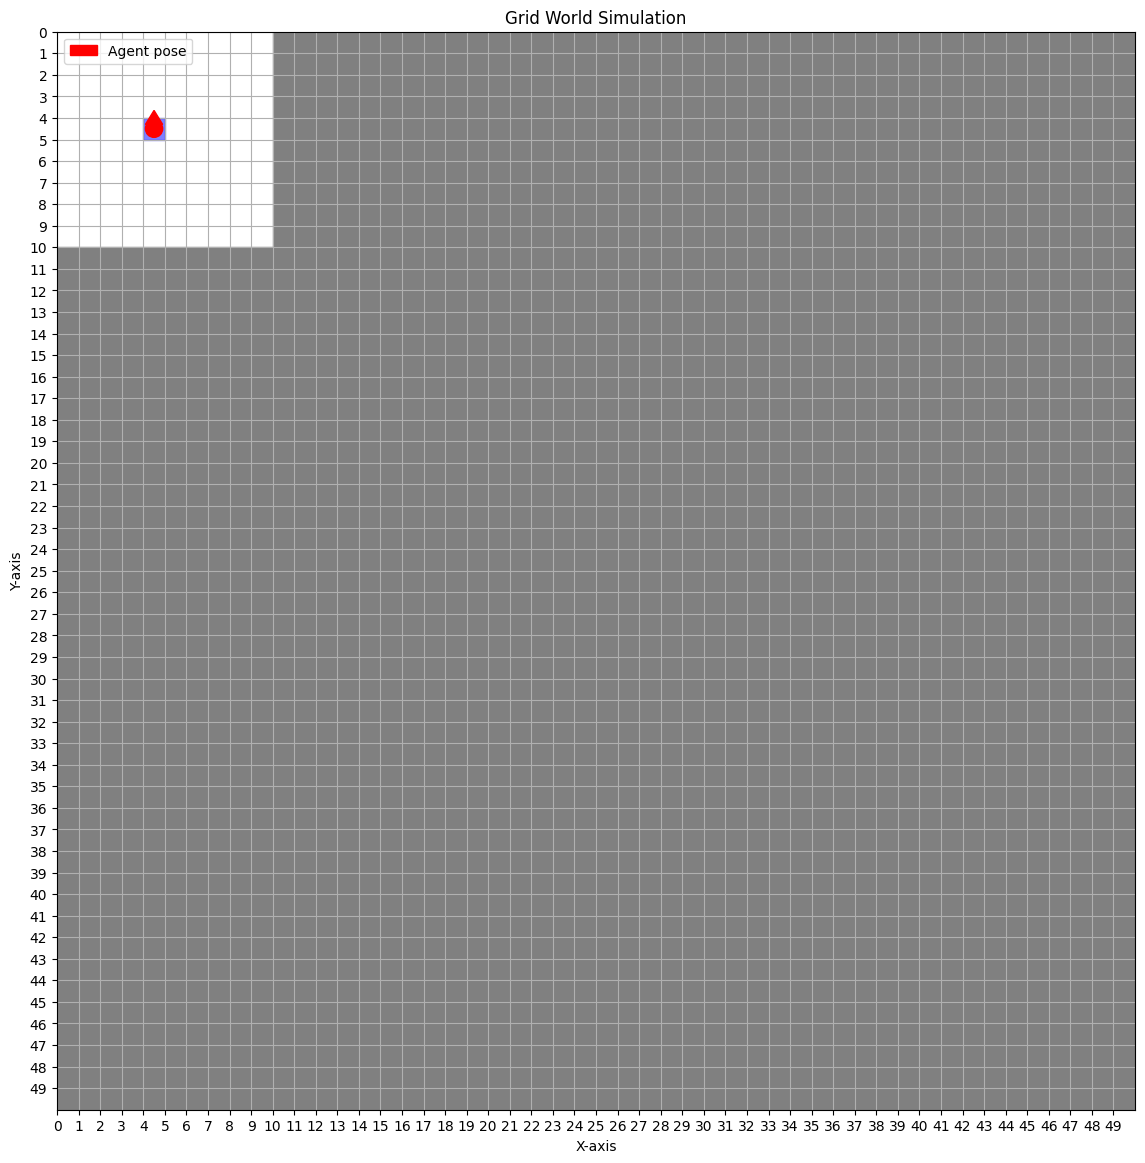

	Iteration 1000


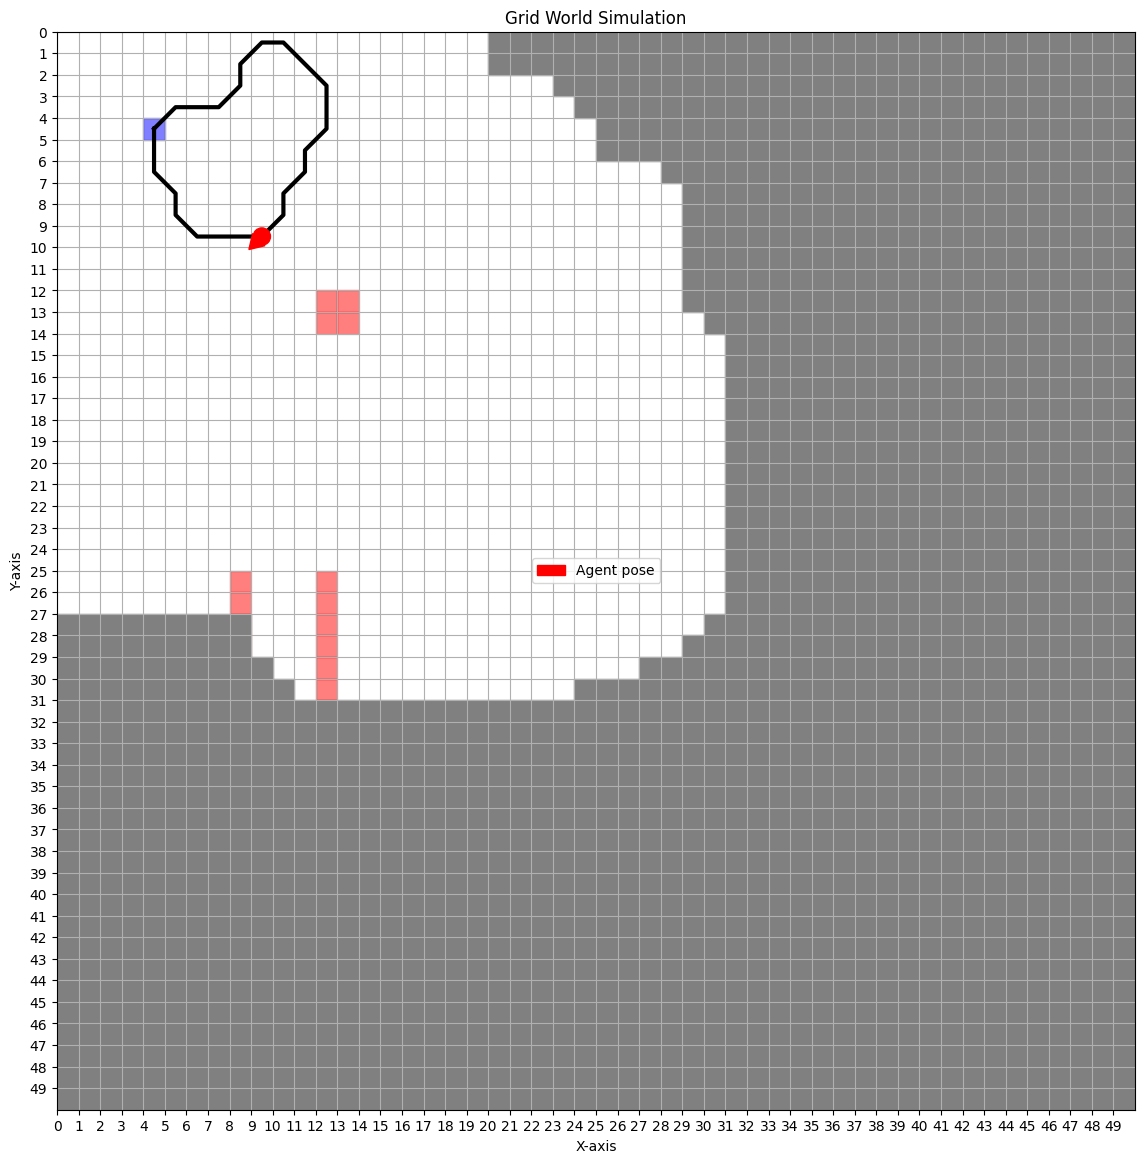

	Iteration 2000


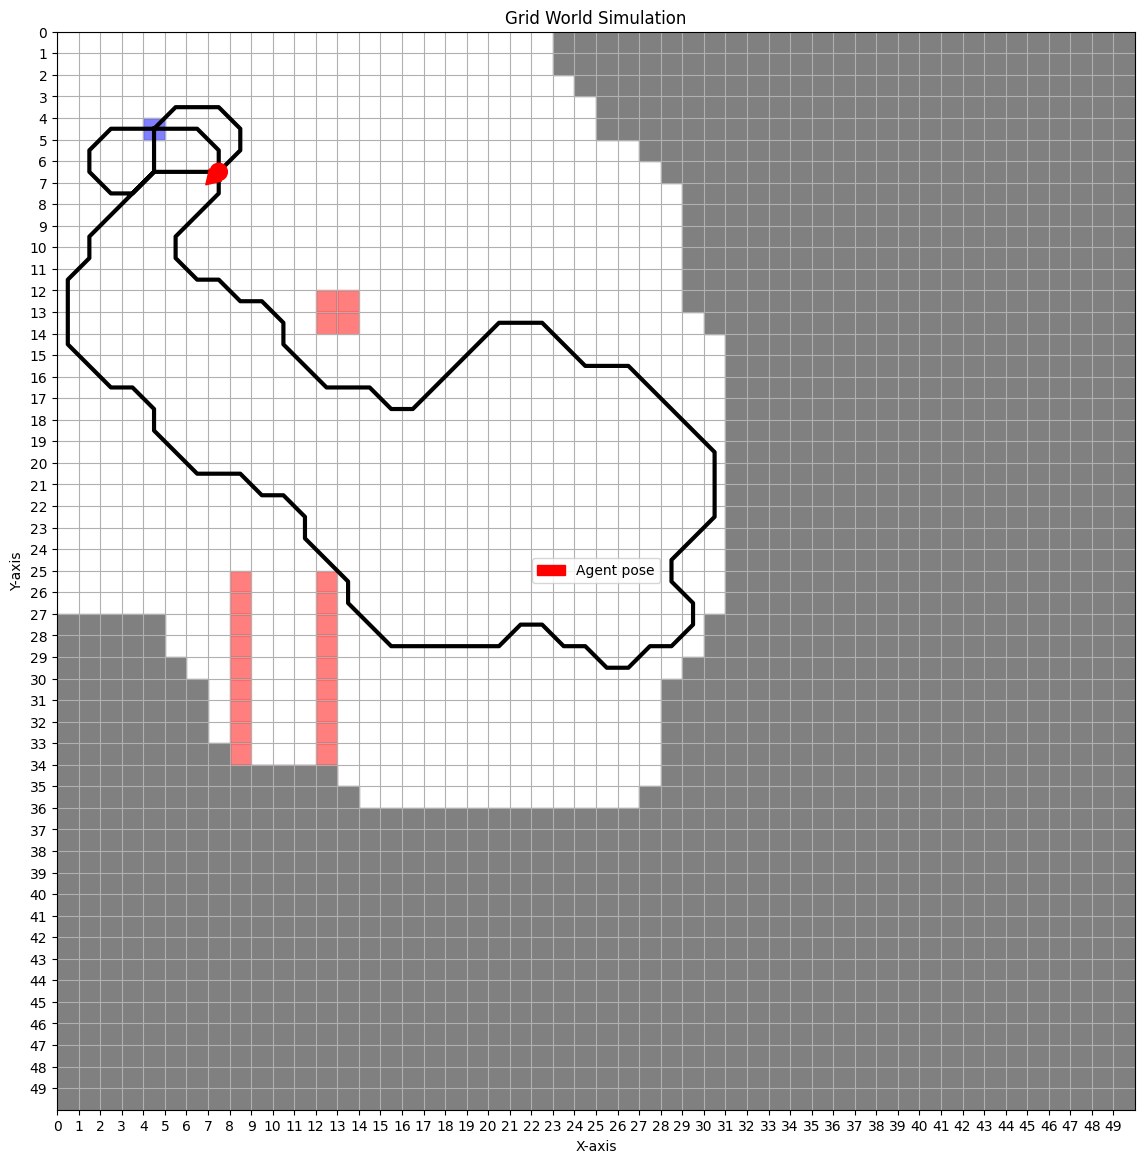

	Iteration 3000


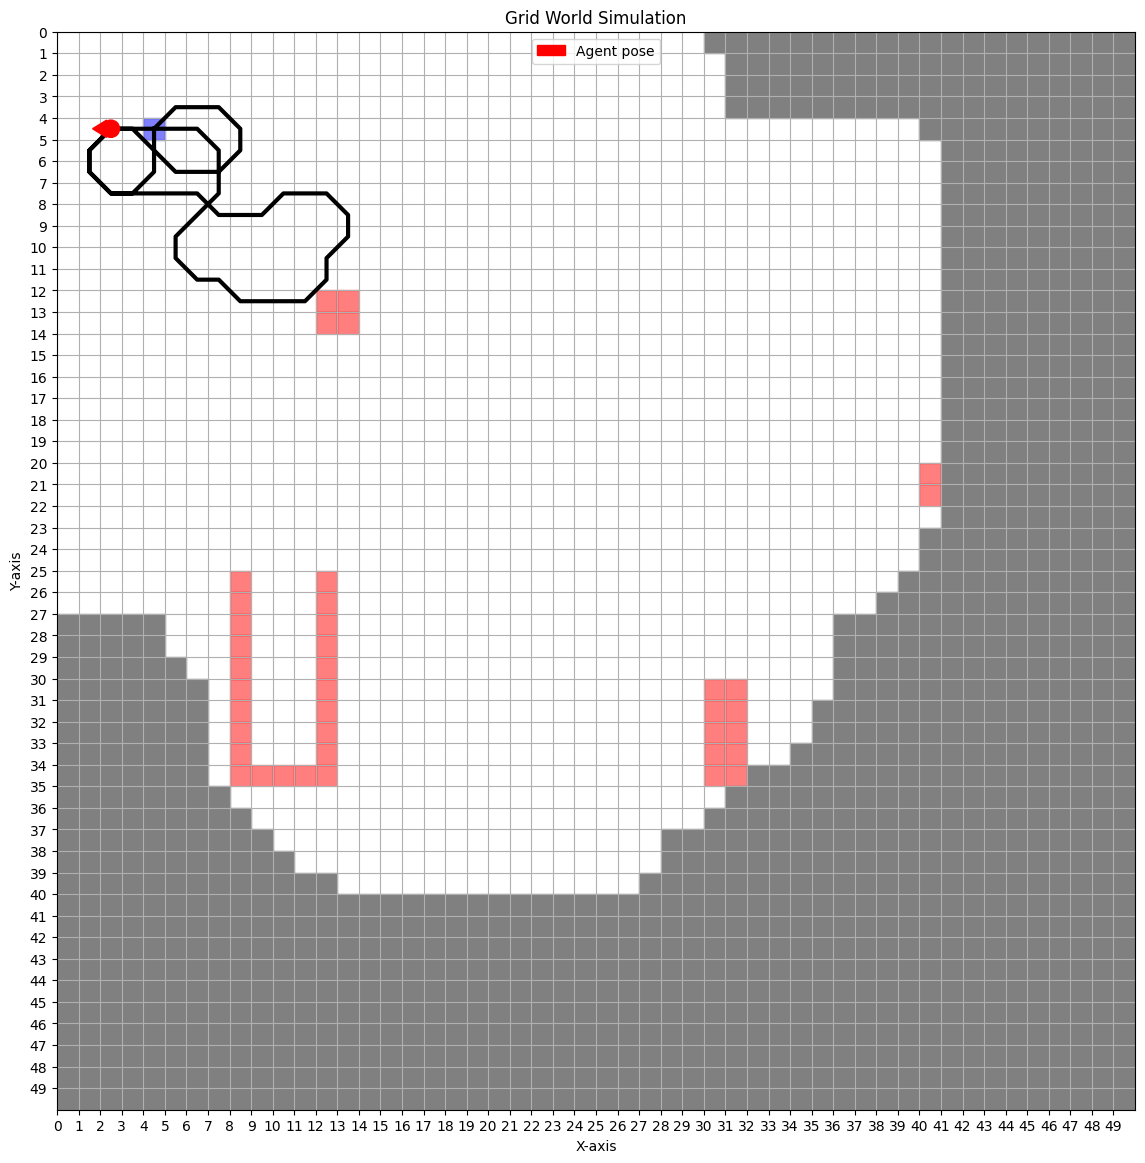

	Iteration 4000


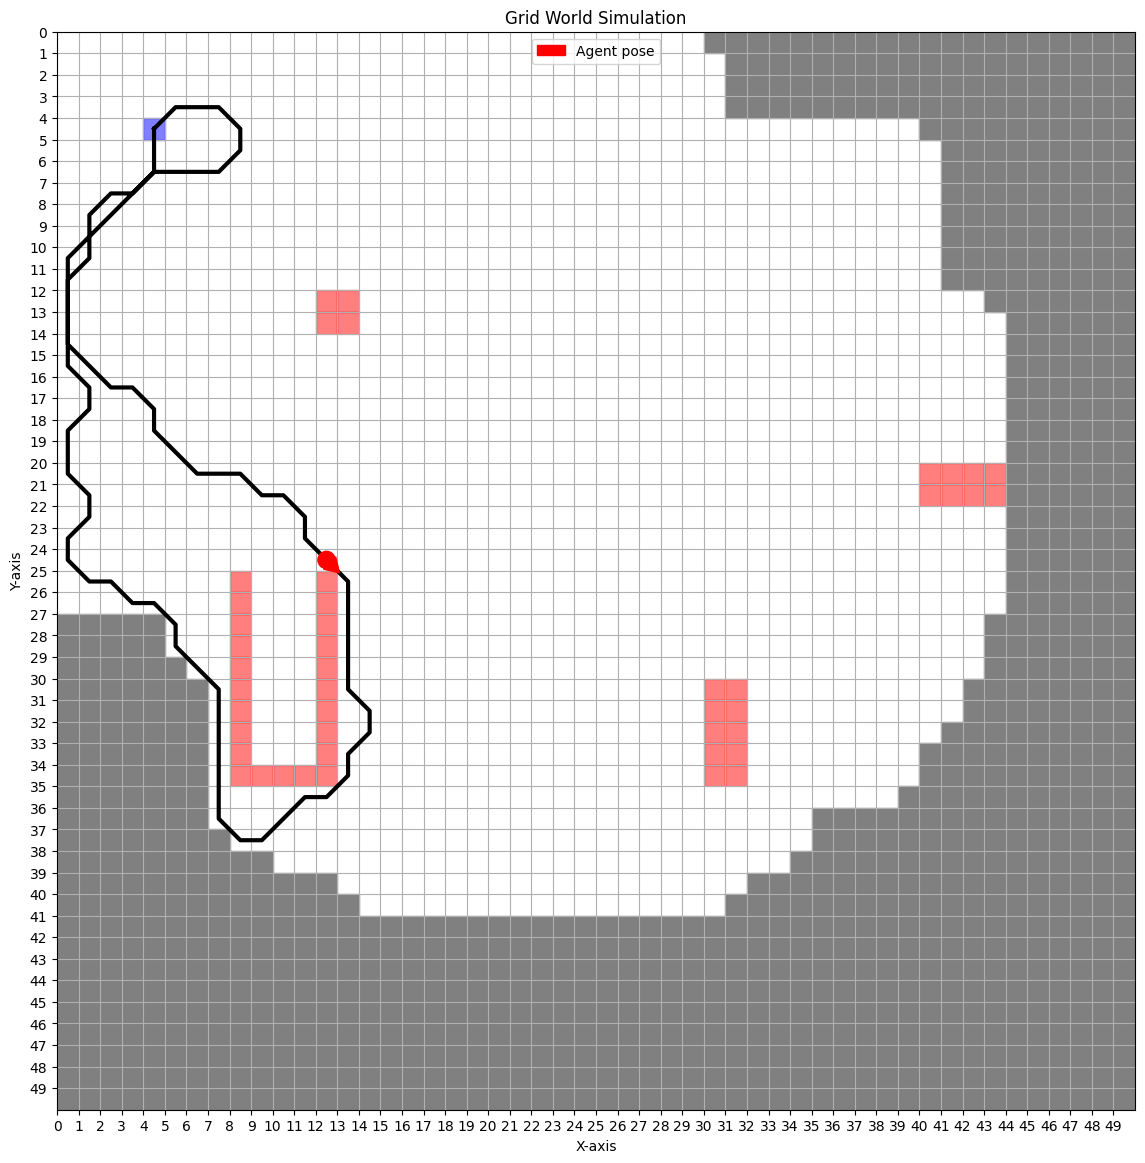

	Iteration 5000


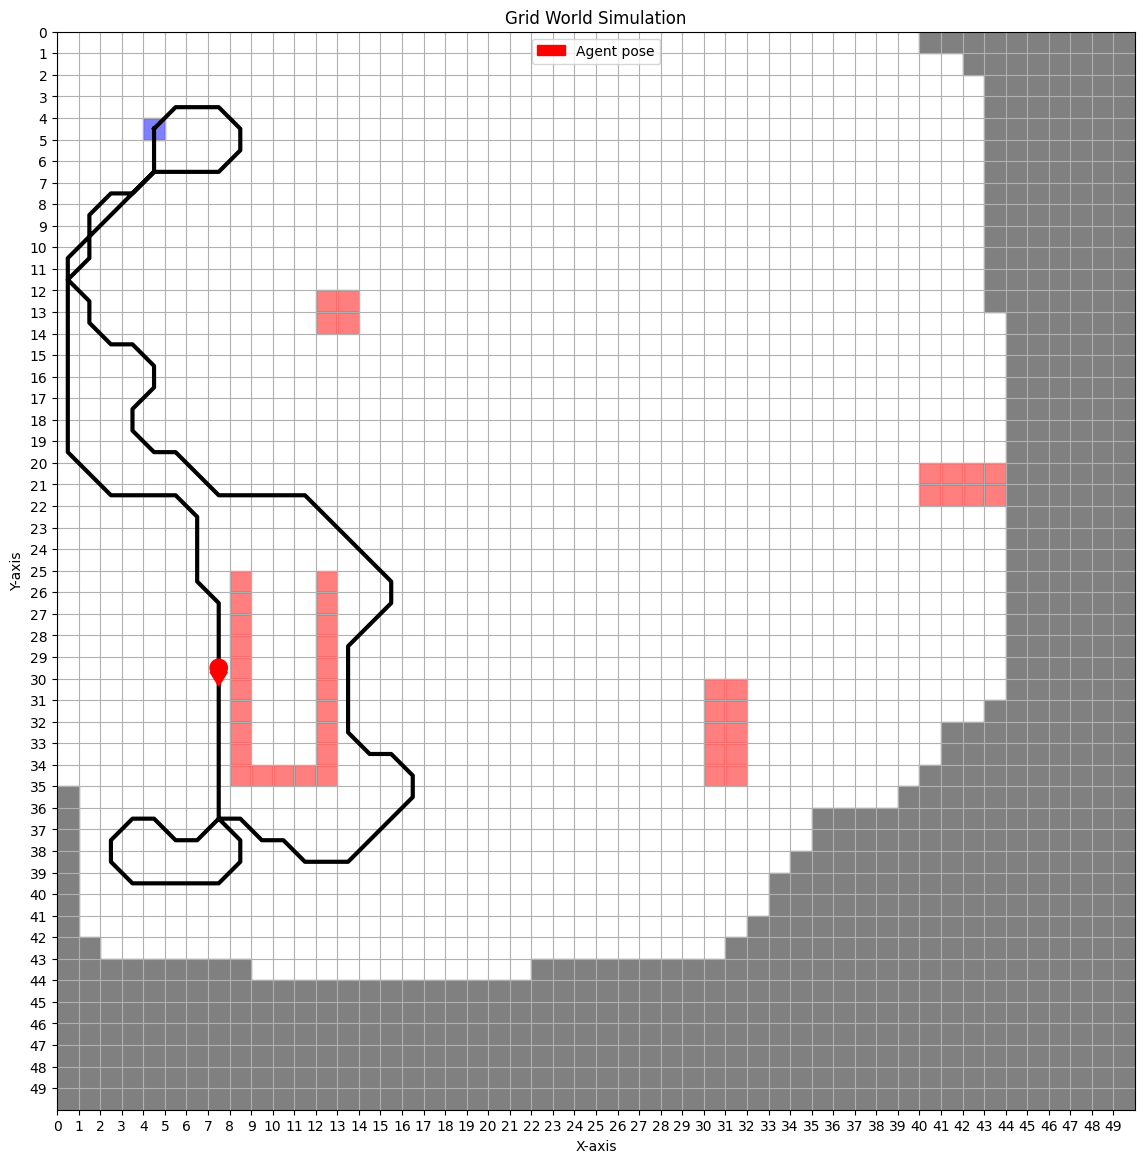

	Iteration 6000


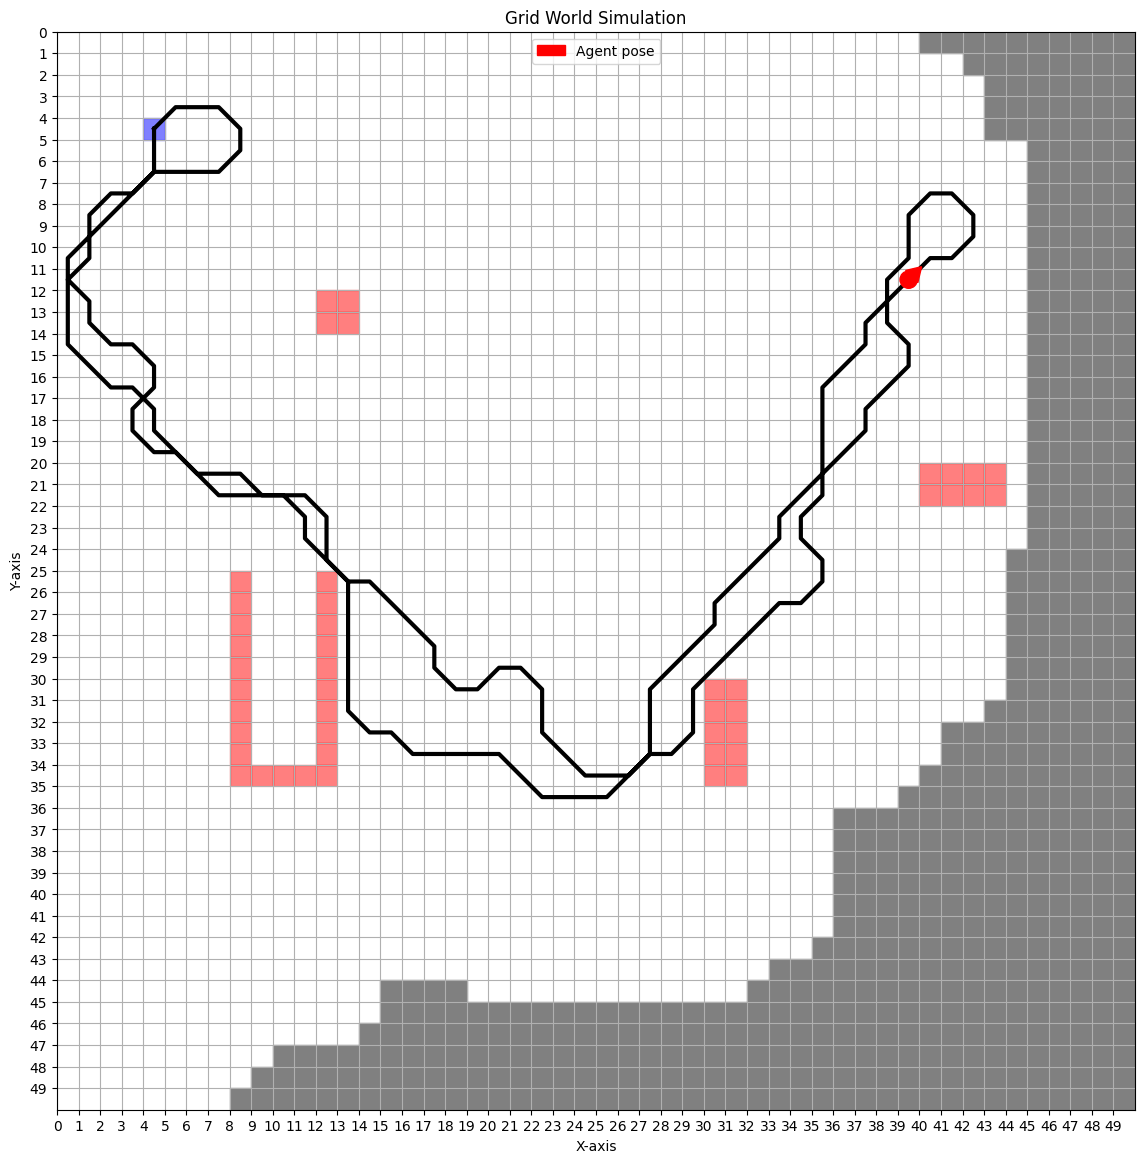

	Iteration 7000


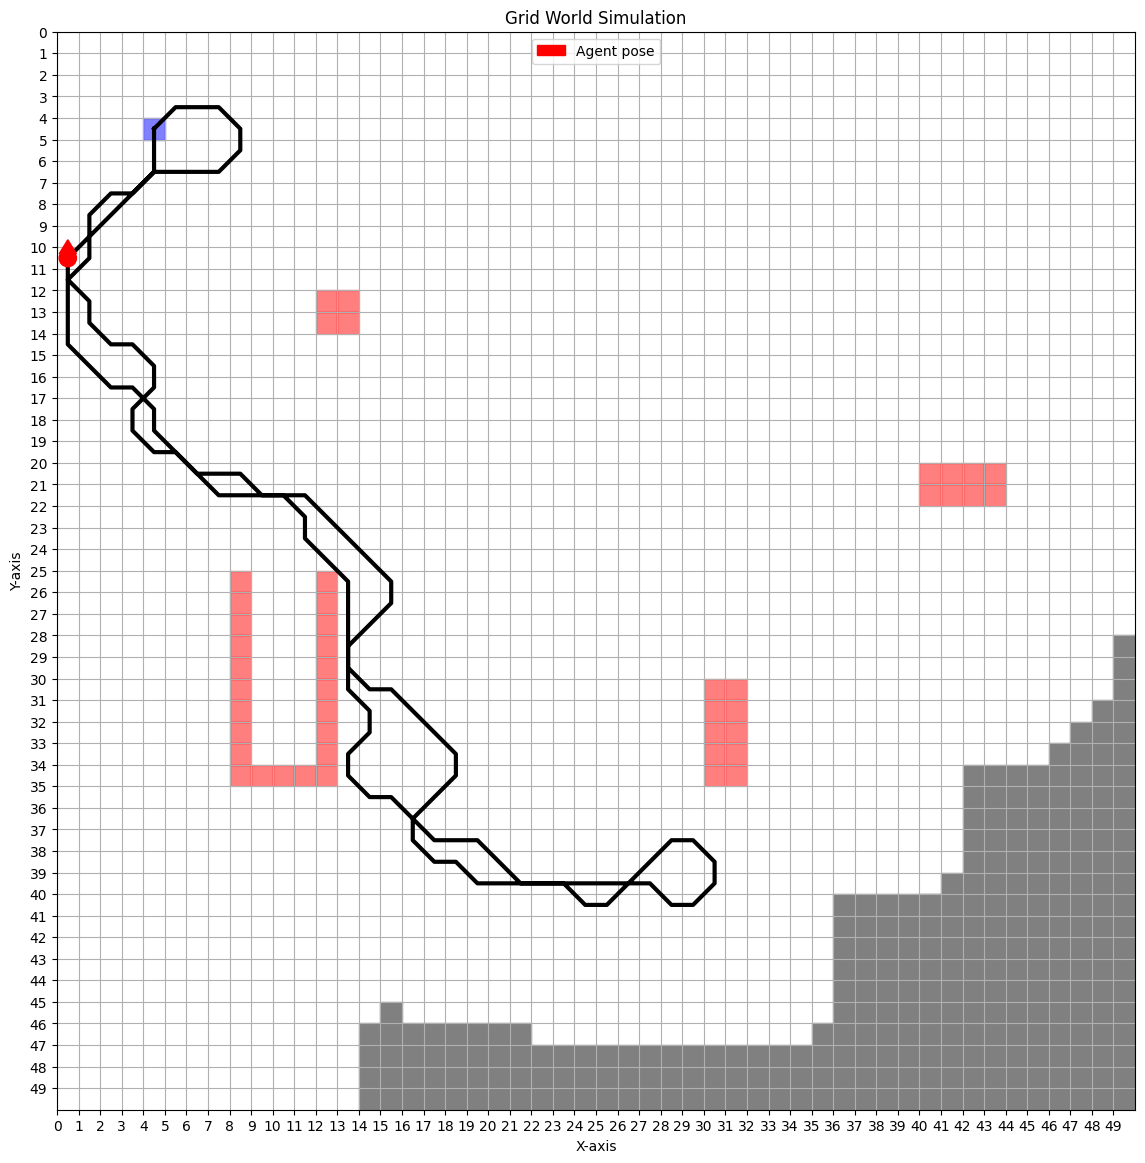

	Goal reached, iteration: 7859
	agent_trajectory: 
		[(4, 4), (5, 3), (6, 3), (7, 3), (8, 4), (8, 5), (7, 6), (6, 6), (5, 6), (4, 6), (3, 7), (2, 8), (1, 9), (1, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (1, 20), (2, 21), (3, 21), (4, 21), (5, 21), (6, 22), (6, 23), (6, 24), (6, 25), (7, 26), (7, 27), (7, 28), (7, 29), (7, 30), (7, 31), (7, 32), (7, 33), (7, 34), (8, 35), (9, 35), (10, 35), (11, 35), (12, 35), (13, 35), (14, 36), (14, 37), (15, 38), (16, 39), (17, 39), (18, 39), (19, 39), (20, 40), (21, 40), (22, 40), (23, 41), (24, 41), (25, 42), (26, 42), (27, 43), (28, 44), (29, 44), (30, 43), (31, 43), (32, 42), (33, 42), (34, 41), (35, 40), (36, 40), (37, 41), (38, 41), (39, 41), (40, 40)]
	DONE: Iteration: 7859


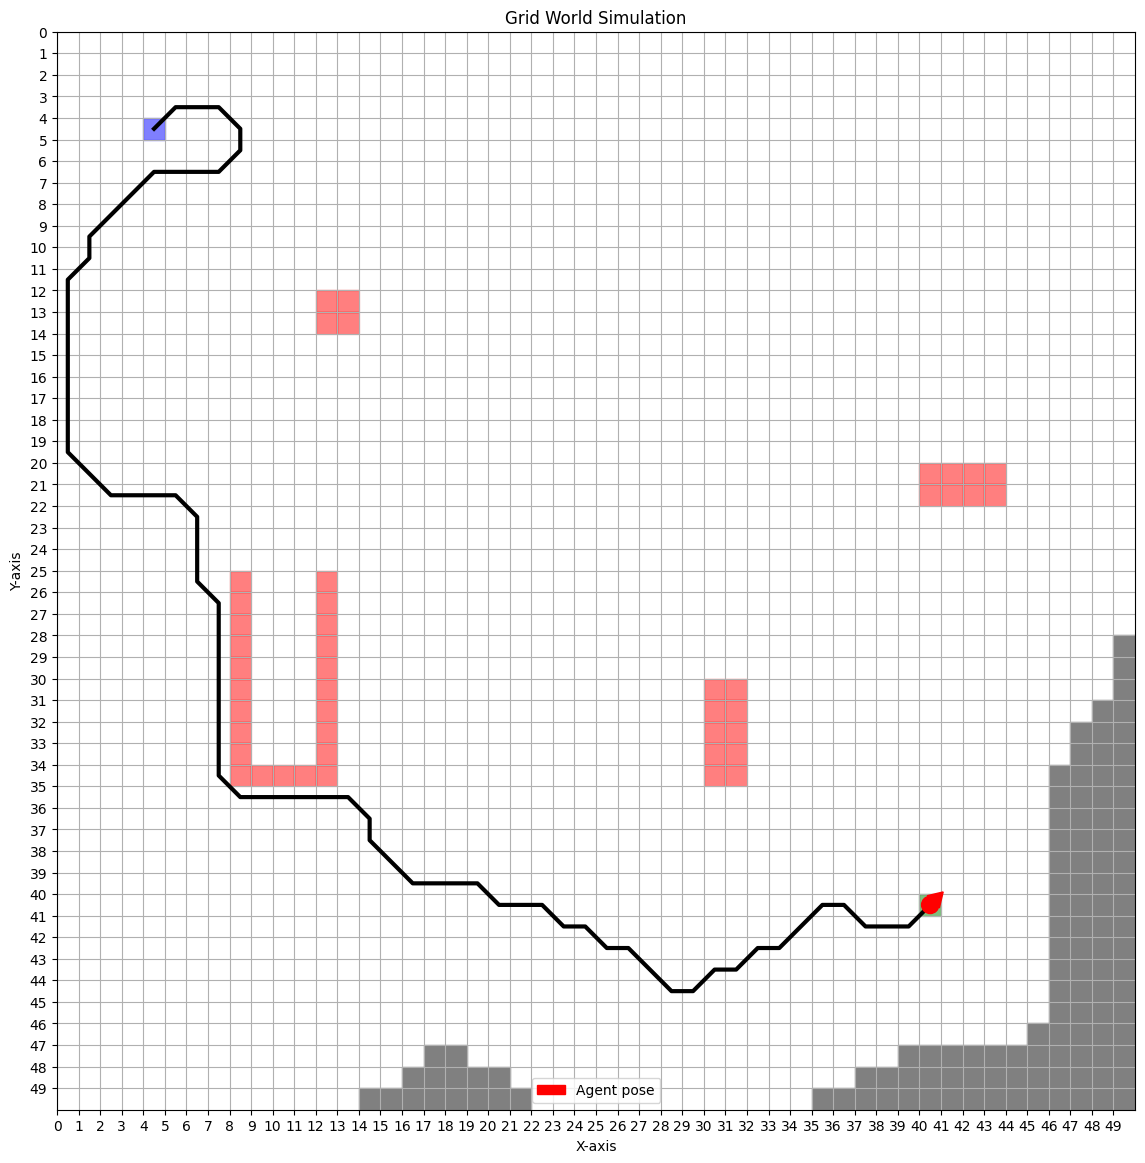

7859

In [19]:
run_simulation(is_receding_horizon=False, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=True)

	Iteration 0
	Iteration 1000


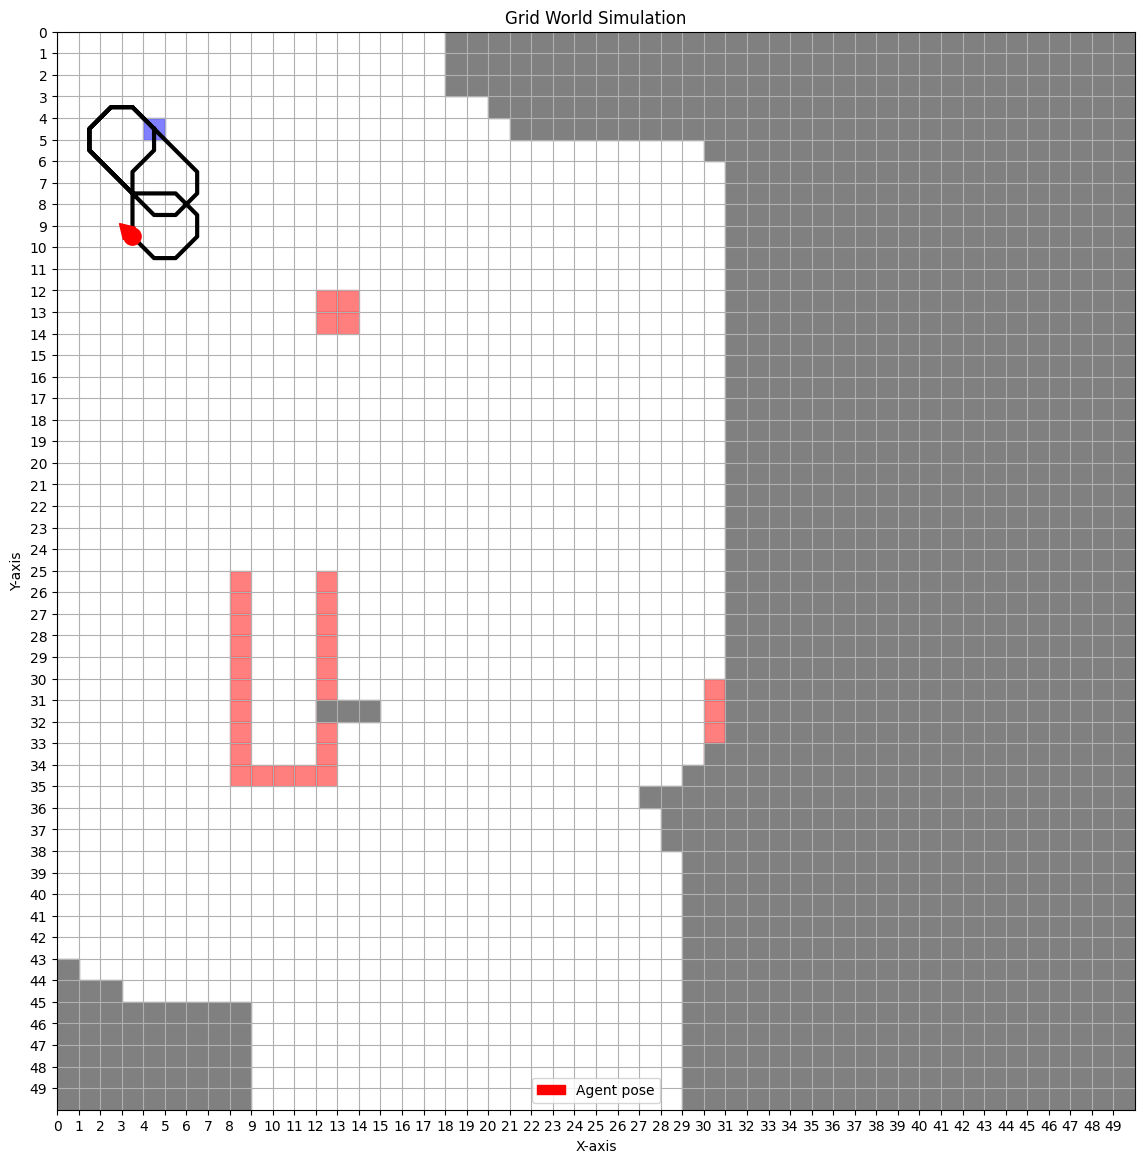

	Iteration 2000


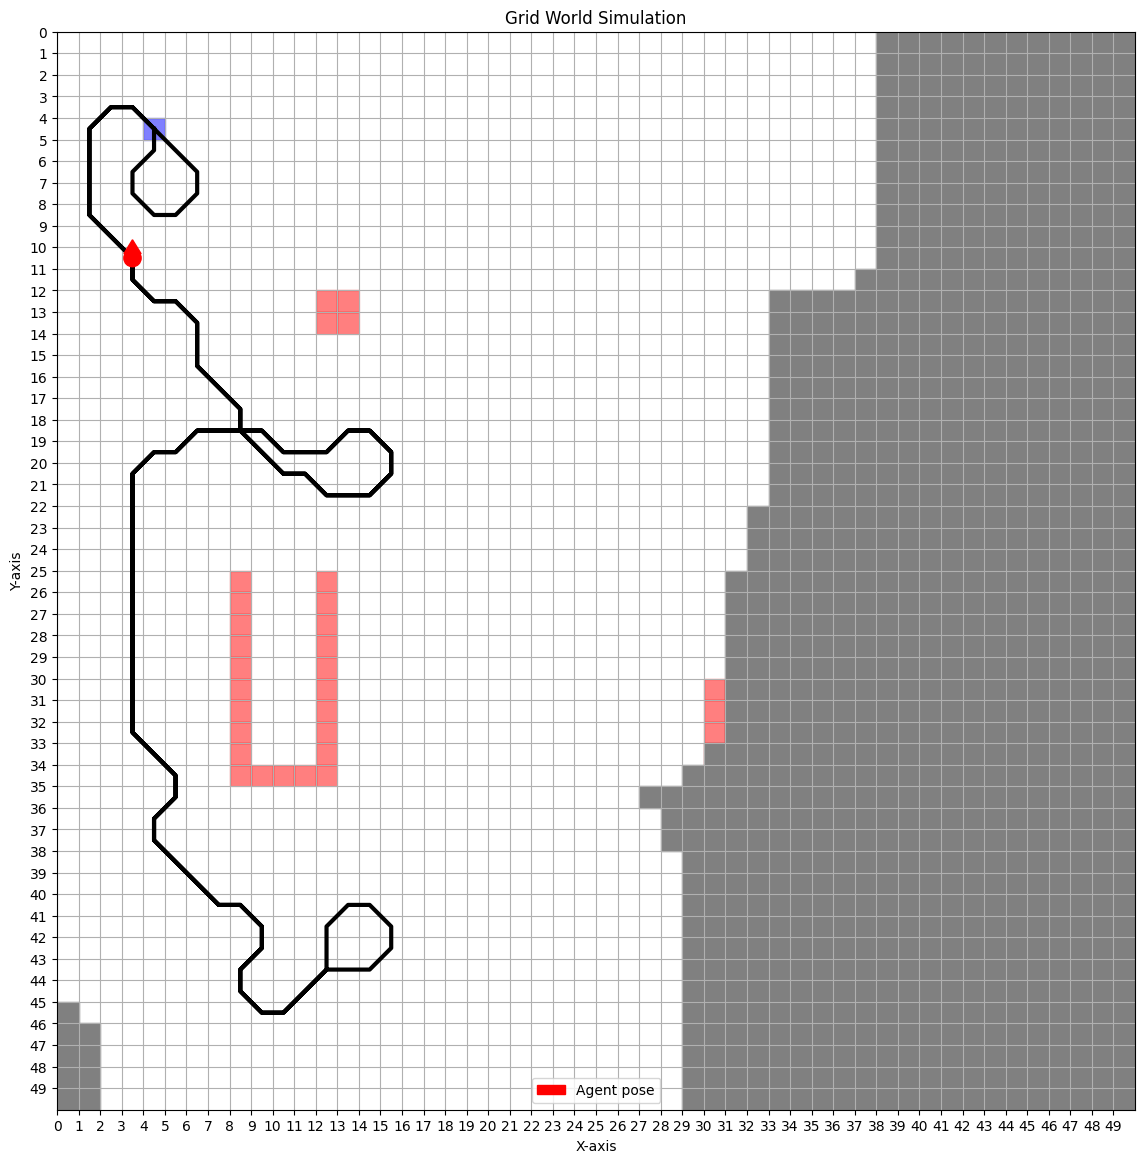

	Iteration 3000


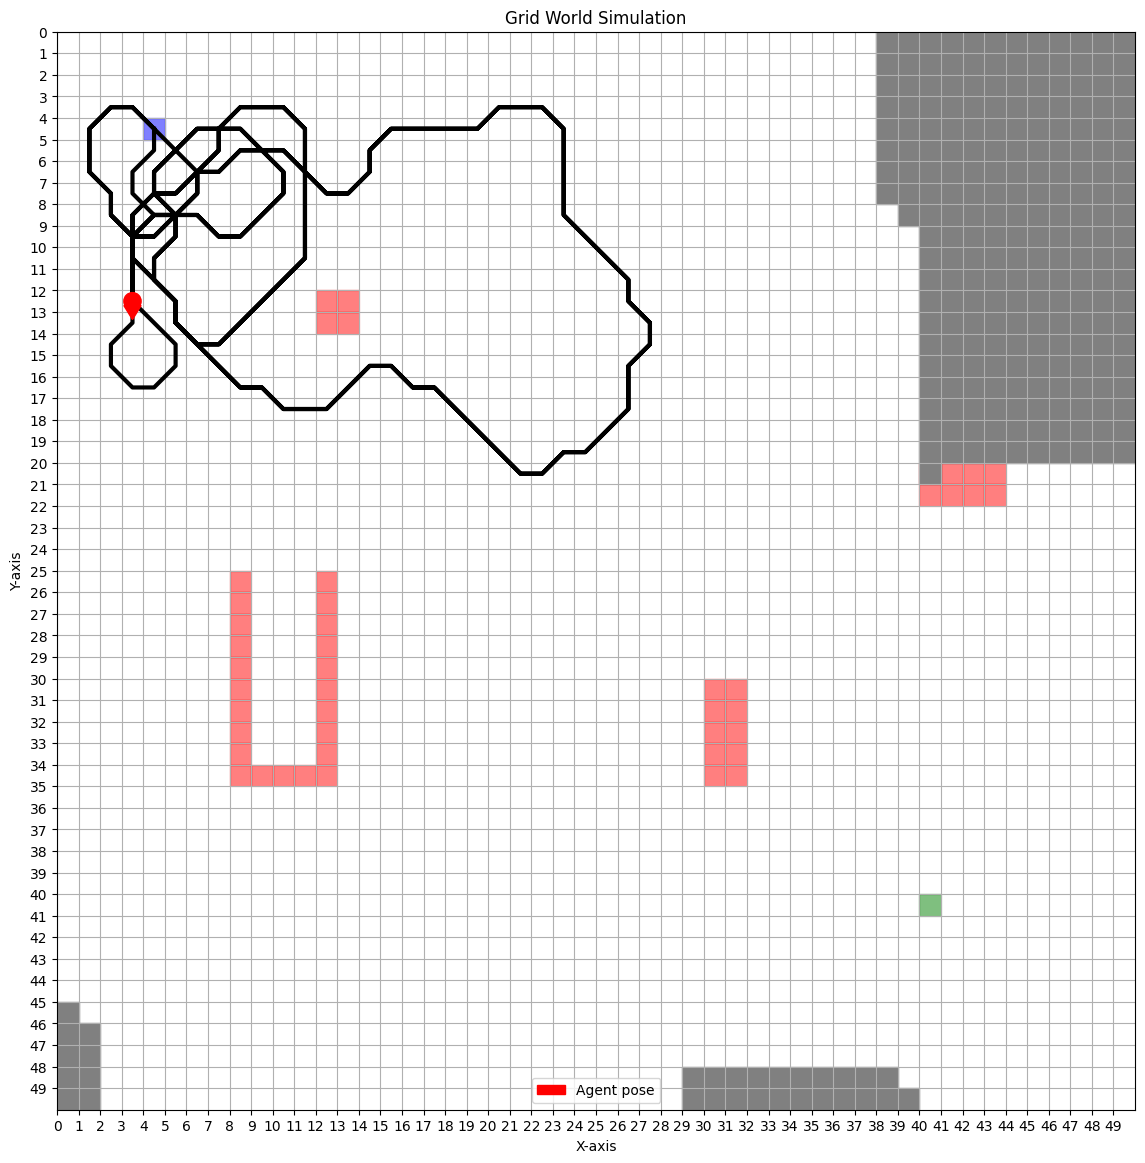

	Iteration 4000


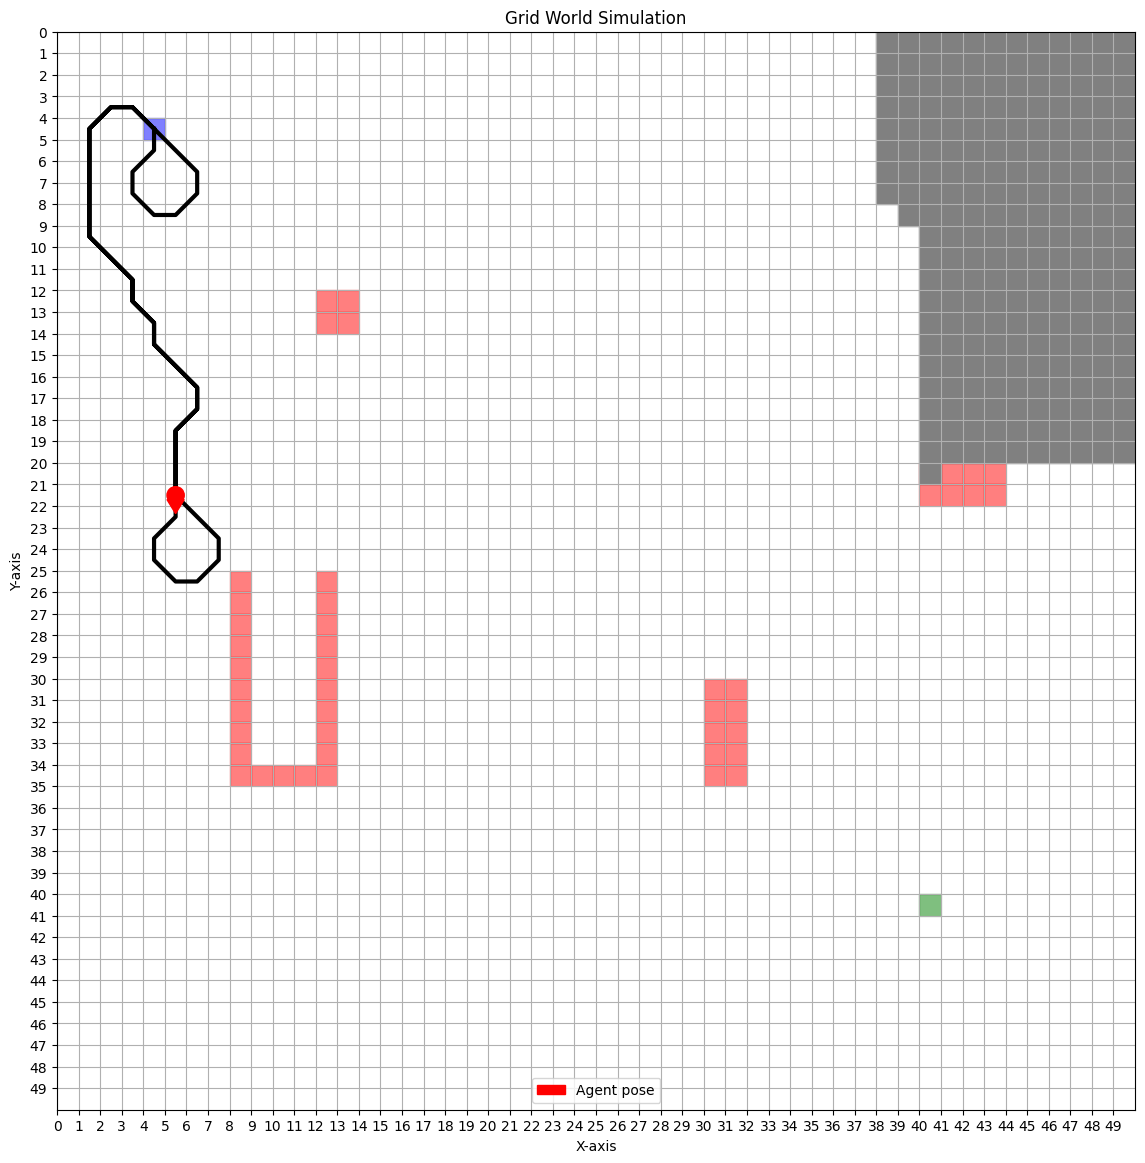

	Iteration 5000


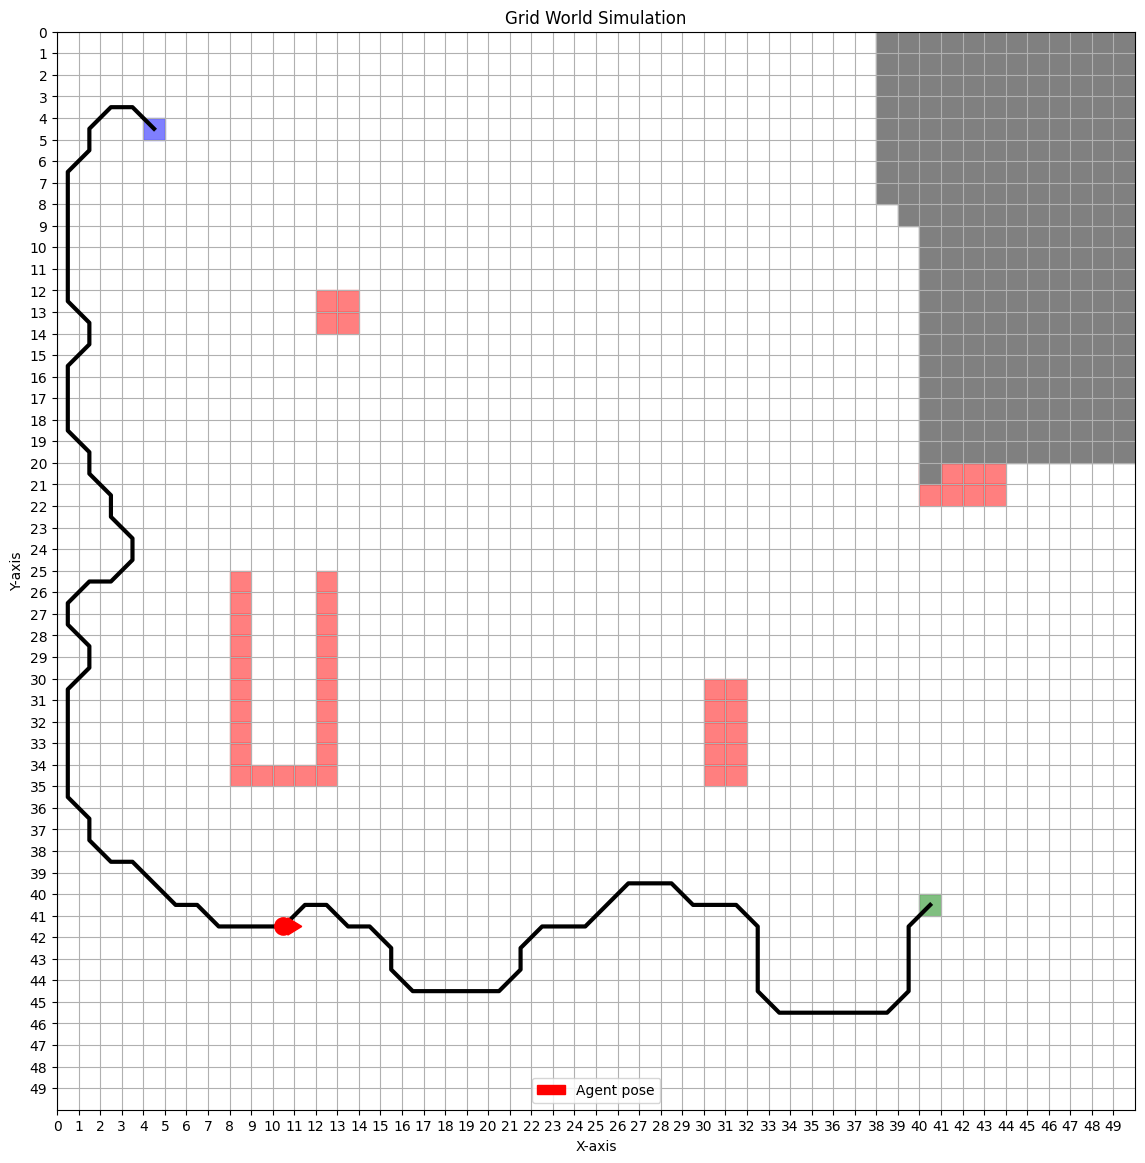

	Goal reached, iteration: 5037
	agent_trajectory: 
		[(4, 4), (3, 3), (2, 3), (1, 4), (1, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (1, 13), (1, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1, 19), (1, 20), (2, 21), (2, 22), (3, 23), (3, 24), (2, 25), (1, 25), (0, 26), (0, 27), (1, 28), (1, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (1, 36), (1, 37), (2, 38), (3, 38), (4, 39), (5, 40), (6, 40), (7, 41), (8, 41), (9, 41), (10, 41), (11, 40), (12, 40), (13, 41), (14, 41), (15, 42), (15, 43), (16, 44), (17, 44), (18, 44), (19, 44), (20, 44), (21, 43), (21, 42), (22, 41), (23, 41), (24, 41), (25, 40), (26, 39), (27, 39), (28, 39), (29, 40), (30, 40), (31, 40), (32, 41), (32, 42), (32, 43), (32, 44), (33, 45), (34, 45), (35, 45), (36, 45), (37, 45), (38, 45), (39, 44), (39, 43), (39, 42), (39, 41), (40, 40)]
	DONE: Iteration: 5037


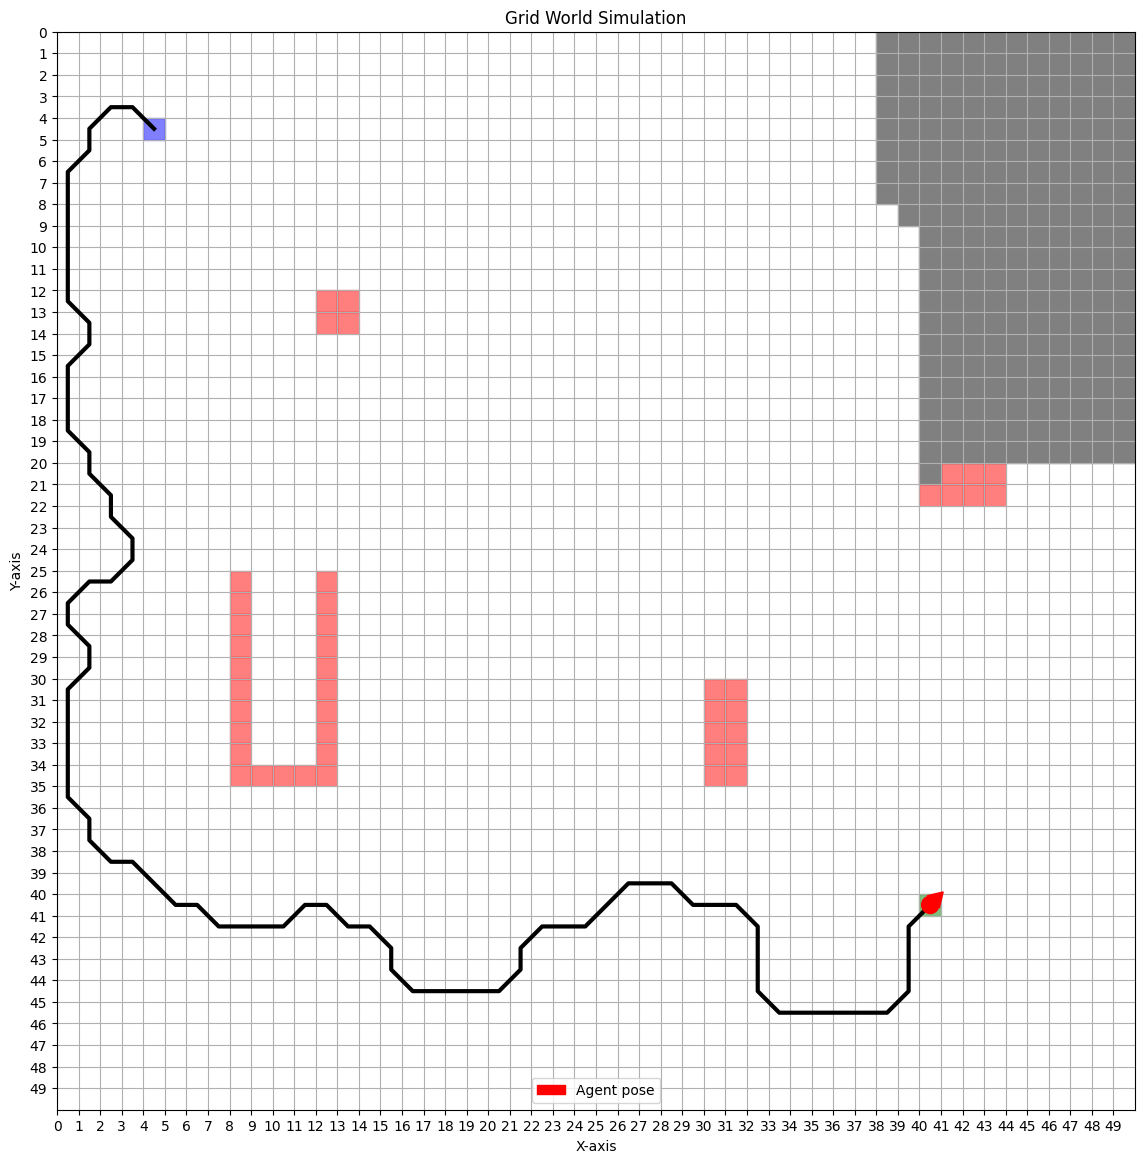

5037

In [16]:
run_simulation(is_receding_horizon=True, start_tyx=start_tyx, goal_tyx=goal_tyx, obstacles=obstacles, plot=True, alpha=0.97)